<a href="https://colab.research.google.com/github/Hongkai040/Tutorials-Homework-Notebooks-1/blob/main/Hongkai_week6_Tutorial_2_deep_knowledge_graph_categorical_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 6.2 Thinking with Deep Learning: Week 6 Part 2
# Deep Learning with Knowledge Graphs, Tabular, and Categorical Data

__Instructor:__ James Evans

__Notebook Author:__ Bhargav Srinivasa Desikan

__Teaching Assistants & Course Organizers:__ Likun Cao & Partha Kadambi 

In this notebook, we will be exploring different neural network models for tabular and categorical data, as well as for knowledge graphs. 

The first two sections focus on tabular and categorical data, before touching on joint embeddings, with a final section on knowledge graphs.

In [ ]:
# empty cell

# Deep Neural Models for Tabular and Categorical Data

**Note:** you saw FFNNs in our week2 tutorials, but we reintroduce them here as these kind of networks are especially suited for modeling *tabular*, *structured* (aka "traditional" social science data, as from surveys or censuses). If you didn't use these FFNN variants in a prior week, we recommend you try it now!

A deep feed forward network is one where we typically have more than 2 layers of nodes; originally these were also fully connected, but regularizations have altered that. The crucial distinction here is that while a shallow network could get away with not needing to backpropagate values through the network, a deep network must crucially be able to do this. It is with the Stochastic Gradient Descent powered backpropagation that we are able to optimize layers of weights for powerful models. 

The last time we saw deep neural models, we added a single layer to our shallow network (refer to [tut 1.2](https://colab.research.google.com/drive/18NT8eyzhlDN9h-lb6svRsbxJ6r3tPNRU?usp=sharing). In this section, we will try different variations of deep models, and use the example in the Keras documentation, *Structured data learning with Wide, Deep, and Cross networks* ([Keras - Salama, 2020](https://keras.io/examples/structured_data/wide_deep_cross_networks/)). 

**IMPORTANT NOTE**: this sort of model includes many new topics, so you may not understand every aspect of this model right away. What is important to get from this example, however, is the kind of data we are feeding into the model, the parameters of the model, and the task. In this case, the setting is a mental health deataset. Notice the way the data is set up, and the parts of the neural network - the loss function, activation functions, optimisers, and so on. 

This example demonstrates how to do structured data classification using these 
two modeling techniques. It is highly recommended to skim these two articles before diving in! The description below these two mentioned models is the abstract of the associated papers. 

1. [Wide & Deep](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) models:

- The human brain is a sophisticated learning machine, forming rules by memorizing everyday events (“sparrows can fly” and “pigeons can fly”) and generalizing those learnings to apply to things we haven't seen before (“animals with wings can fly”). Perhaps more powerfully, memorization also allows us to further refine our generalized rules with exceptions (“penguins can't fly”). As we were exploring how to advance machine intelligence, we asked ourselves the question—can we teach computers to learn like humans do, by combining the power of memorization and generalization? It's not an easy question to answer, but by jointly training a wide linear model (for memorization) alongside a deep neural network (for generalization), one can combine the strengths of both to bring us one step closer. At Google, we call it Wide & Deep Learning. It's useful for generic large-scale regression and classification problems with sparse inputs (categorical features with a large number of possible feature values), such as recommender systems, search, and ranking problems.

2. [Deep & Cross](https://arxiv.org/abs/1708.05123) models: 

- Feature engineering has been the key to the success of many prediction models. However, the process is nontrivial and often requires manual feature engineering or exhaustive searching. DNNs
are able to automatically learn feature interactions; however, they
generate all interactions implicitly, and are not necessarily efficient in learning all types of cross features. In this paper, we propose the Deep & Cross Network (DCN) which keeps the benefits of
a DNN model, and beyond that, it introduces a novel cross network
more efficient in learning certain bounded-degree feature
interactions. In particular, DCN explicitly applies feature crossing
at each layer, requires no manual feature engineering, and adds
negligible extra complexity to the DNN model. Our experimental
results have demonstrated its superiority over the state-of-art algorithms on the CTR prediction dataset and dense classification
dataset, in terms of both model accuracy and memory usage.


In [186]:
!pip install tensorflow==2.4.1

#restart the kernel after installation.

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### DataSet
For this exercise, we use "Mental Health in Tech Survey" data, which is an open source survey data about mental health conditions of workers in the tech industries. You can find the data at Kaggle:

https://www.kaggle.com/osmi/mental-health-in-tech-survey

The basic idea of this exercise is to predict workers' mental health problems with working conditions. 

We provided a cleaned version of this data. The predictors contain 1 continuous variable (age), 3 dummies (Do you work remotely? Is your employer primarily a tech company? Does your employer provide any mental health benefits?) and 2 categorical variables (gender-male/female/other; can you discuss your mental health issue with supervisors-yes/sometimes/no).

The outcome is an answer to the question: If you have a mental health condition, do you feel it interferes with your work? The DV is measured with a 5-categorical variable: NA (no mental health condition), never, rarely, sometimes, often. 

Let's start with our models!


We use a google drive stored file, but you can also upload it. 

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/week 6/mental health.csv')

In [ ]:
# train, test split
train_splits = []
test_splits = []

for _, group_data in df.groupby("interfere"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

Train split size: 1074
Test split size: 185


In [ ]:
df[0:5]

,age,remote,benefits,tech,gender,supervisor,interfere
0,8,1,1,1,other,yes,4
1,21,0,0,1,other,some of them,3
2,32,0,0,1,other,no,4
3,28,0,0,1,other,some of them,2
4,27,1,1,1,other,yes,4


In [ ]:
CSV_HEADER = ['age','remote','benefits','tech','gender','supervisor','interfere']

TARGET_FEATURE_NAME = "interfere"

TARGET_FEATURE_LABELS = [ "1", "2", "3", "4","5"]

NUMERIC_FEATURE_NAMES = ["age", "remote",'benefits','tech']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": list(df["gender"].unique()),
    "supervisor": list(df["supervisor"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [ ]:
#setup
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()



learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]

In [ ]:
#create input
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
#encode features

from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            value_index = index(inputs[feature_name])
            if use_embedding:
                embedding_dims = int(math.sqrt(len(vocabulary)))
                embedding_ecoder = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                encoded_feature = embedding_ecoder(value_index)
            else:
                onehot_encoder = CategoryEncoding(output_mode="binary")
                onehot_encoder.adapt(index(vocabulary))
                encoded_feature = onehot_encoder(value_index)
        else:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

### Experiment 1: a baseline model

In the first experiment, let's create a multi-layer feed-forward network,
where the categorical features are one-hot encoded. 

**Note**: Some new terms here! We see a Batch Normalisation layer. We will encounter these in our second notebook on regularisation, but for a brief explanation:

Batch normalization tries to reduce the “internal covariate shift” between training and testing data. Internal covariate shift is the change in the distribution of network activations due to the change in paramaters during training. In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does the distribution of inputs to subsequent layers. These shifts in input distributions can be problematic for training neural networks, especially deep neural networks that could have a large number of layers. Batch normalization tries to mitigate this. You can check out [this](https://arxiv.org/abs/1502.03167) paper where the idea of mitigating internal covariance shift with batch normalization was first introduced. 

We also see Dropout, another approach from the regularisation universe. Dropout involves injecting noise while computing each internal layer during forward propagation by randomly and temporarily dropping out a fraction of neurons during training for one epoch of training.

![Dropout](https://d2l.ai/_images/dropout2.svg)


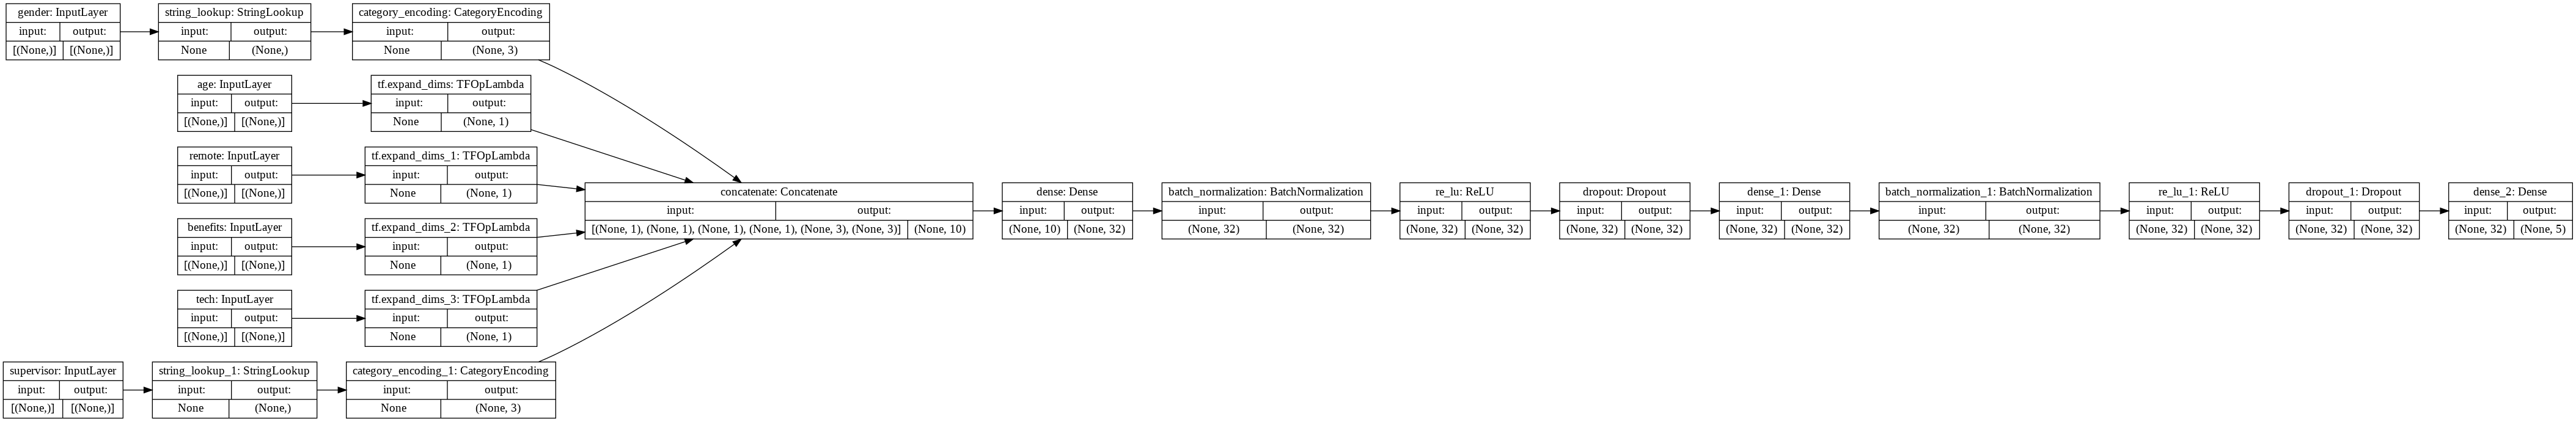

In [ ]:
#baseline model

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


In [ ]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
5/5 [==============================] - 2s 11ms/step - loss: 1.9568 - sparse_categorical_accuracy: 0.1808
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.8595 - sparse_categorical_accuracy: 0.1937
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7967 - sparse_categorical_accuracy: 0.2112
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7654 - sparse_categorical_accuracy: 0.1969
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7514 - sparse_categorical_accuracy: 0.2214
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7180 - sparse_categorical_accuracy: 0.2183
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 1.6816 - sparse_categorical_accuracy: 0.2435
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 1.6310 - sparse_categorical_accuracy: 0.2676
Epoch 9/50
5/5 [==============================] - 0

The baseline linear model achieves ~76% test accuracy.

### Experiment 2: Wide & Deep model

In the second experiment, we create a Wide & Deep model. The wide part of the model
is a linear model, while the deep part is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the
dense representation of the input features for the deep part of the model.

Note that every input feature contributes to both parts of the model with different
representations. You can see that we merge the layers near the end before reaching the output of the model. 

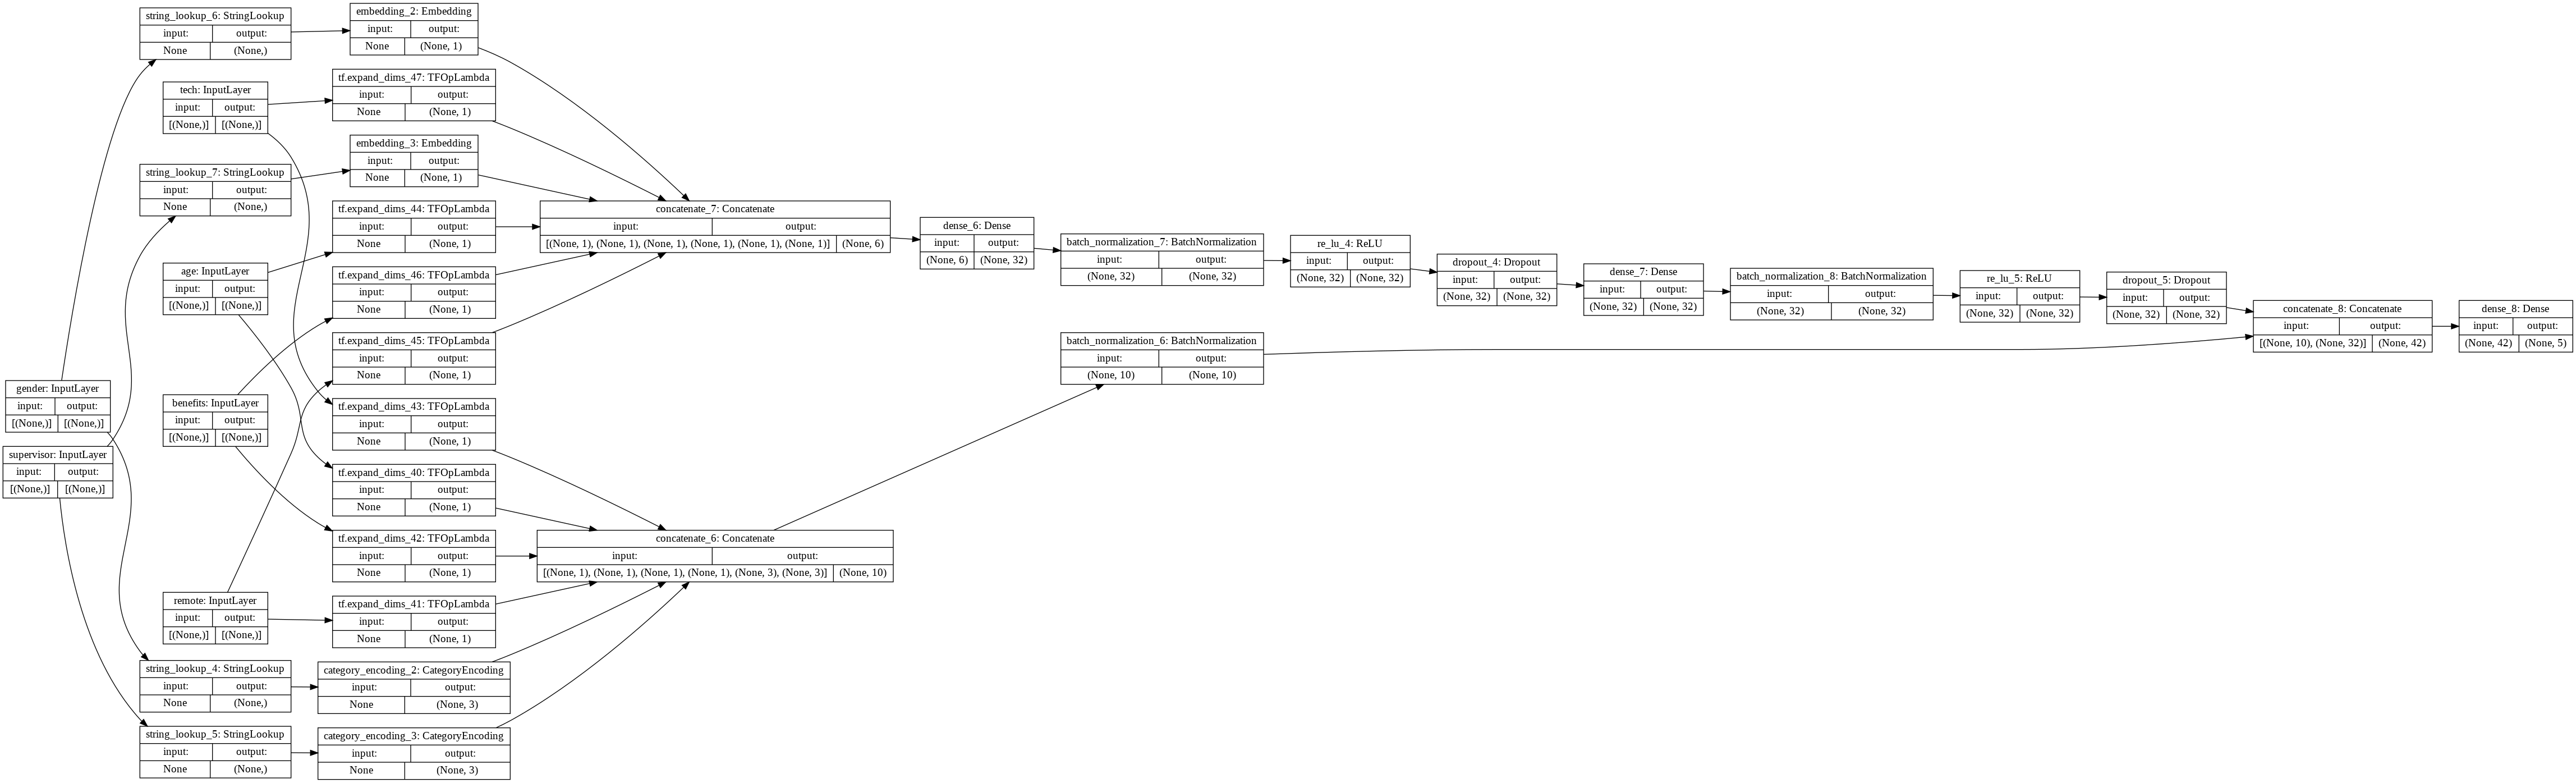

In [ ]:
#wide and deep
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
5/5 [==============================] - 1s 6ms/step - loss: 1.9186 - sparse_categorical_accuracy: 0.2377
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.8483 - sparse_categorical_accuracy: 0.2337
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 1.8262 - sparse_categorical_accuracy: 0.2396
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 1.7788 - sparse_categorical_accuracy: 0.2398
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7459 - sparse_categorical_accuracy: 0.2631
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7424 - sparse_categorical_accuracy: 0.2641
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7173 - sparse_categorical_accuracy: 0.2665
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7117 - sparse_categorical_accuracy: 0.2839
Epoch 9/50
5/5 [==============================] - 0s

The wide and deep model achieves ~79% test accuracy.

### Experiment 3: Deep & Cross model

In the third experiment, we create a Deep & Cross model. The deep part of this model
is the same as the deep part created in the previous experiment. The key idea of
the cross part is to apply explicit feature crossing in an efficient way,
where the degree of cross features grows with layer depth.

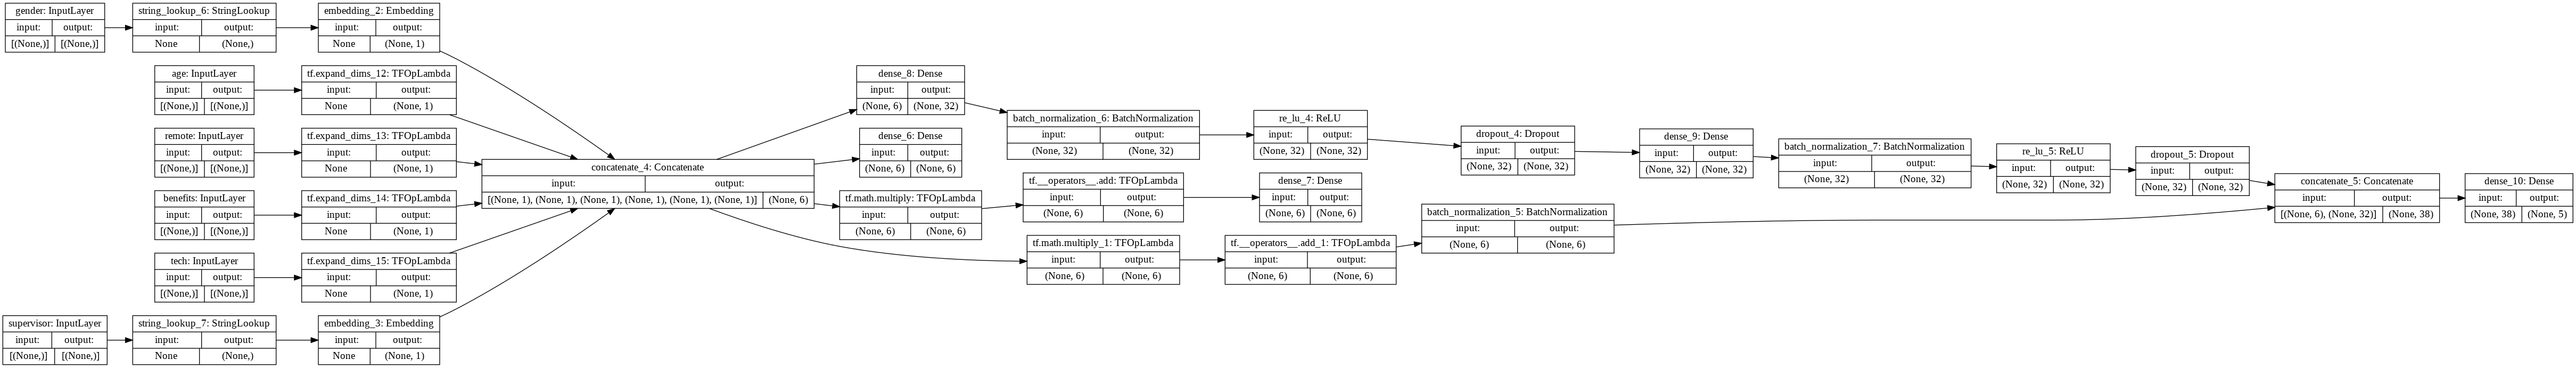

In [ ]:

def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
5/5 [==============================] - 1s 6ms/step - loss: 2.0555 - sparse_categorical_accuracy: 0.1831
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.9448 - sparse_categorical_accuracy: 0.2057
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 1.9156 - sparse_categorical_accuracy: 0.1992
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 1.8392 - sparse_categorical_accuracy: 0.2318
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 1.8469 - sparse_categorical_accuracy: 0.2298
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 1.7943 - sparse_categorical_accuracy: 0.2610
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 1.7810 - sparse_categorical_accuracy: 0.2531
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 1.7190 - sparse_categorical_accuracy: 0.2869
Epoch 9/50
5/5 [==============================] - 0s

The deep and cross model achieves ~81% test accuracy.

### Using the Model for Feature Extraction

Keras models allow you to create a feature extraction version of the model just run. See [this tutorial](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction) for more reasons. By feeding in model inputs and outputs as just the layer you want to receive features for, we create a model that can extract any layer we want. **Note**: We often want to use penultimate layer of the model, directly prior to decision layer--these are the features that the model uses to *make* the ultimate decision. See the following example of an image classification network where we take the layer before the final (Softmax) layer as the output features.

![picture](https://drive.google.com/uc?export=view&id=1pL-PlwtedML4jO2aqEl_Qs1NRYYgqfzU)
![picture](https://drive.google.com/uc?export=view&id=18kdnfUb7nRq2GixmtuhlumvZkOhJqDbR)



In the code below we get one big batch of data from the test, and then pick up the first datapoint to extract the features. 

## Extracting Features

In [ ]:
# embedding extraction
extractor_second_last_layer = keras.Model(inputs=wide_and_deep_model.inputs,
                        outputs=[wide_and_deep_model.layers[-2].output])

extractor_last_layer = keras.Model(inputs=wide_and_deep_model.inputs,
                        outputs=[wide_and_deep_model.layers[-1].output])

In [ ]:
import csv

def get_embedding(data_df,index,category):
    row=data_df.iloc[index]
    with open("row.csv","w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list(row.index))
        writer.writerow(list(row.values))
    sample = get_dataset_from_csv('row.csv', 1)
    for data in sample.as_numpy_iterator():
        data_point = data
    if category=='last':
        return extractor_last_layer(dict(data_point[0]))
    elif category=='second_last':
        return extractor_second_last_layer(dict(data_point[0]))
    else:
        print('category should be either "last" or "second_last" ')

In [ ]:
get_embedding(test_data,100,'last')

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.11822844, 0.24096622, 0.31413406, 0.21894409, 0.10772719]],
      dtype=float32)>

In [ ]:
get_embedding(train_data,500,'second_last')

<tf.Tensor: shape=(1, 42), dtype=float32, numpy=
array([[ 1.0860162 , -0.37736577,  1.2061636 ,  0.5649524 , -0.00222081,
        -0.53127694,  0.5935211 ,  1.1020007 , -0.4002224 , -0.4413664 ,
         0.45677343,  0.41552836,  0.68917644,  0.        ,  0.        ,
         0.        ,  0.        ,  0.7969216 ,  0.        ,  0.28822738,
         0.82343   ,  0.5013692 ,  0.2766388 ,  0.        ,  0.        ,
         0.82386726,  0.83588374,  0.3238405 ,  0.88354206,  0.        ,
         0.        ,  0.5454124 ,  0.30825227,  0.        ,  1.1464876 ,
         0.674133  ,  0.4126112 ,  0.        ,  0.5152475 ,  0.81858134,
         0.21983206,  0.        ]], dtype=float32)>

### Conclusion

You can use Keras Preprocessing Layers to easily handle categorical features
with different encoding approaches, including one-hot encoding and feature embedding.
Moreover, different model architectures — like wide, deep, and cross networks
— have different advantages, with respect to distinct dataset properties.
You can explore using them independently or combine them to achieve the best result for your structured (e.g., tabular, rectangular) dataset.

# Categorical and Tabular Embeddings

https://www.fast.ai/2018/04/29/categorical-embeddings/

Rather than simply drawing out features of a dataset relevant for a supervised classification task, we may want to achieve an unsupervised embedding that allows us identify patterns in tables and tabular data. When the rows represent persons, and the columns represent sparse choices, opinions or preferences, unsupervised tabular embeddings have become widely used for collaborative filtering, which discovers associations between persons (rows) and items (columns) for preference prediction and item recommendation. Dense tables can also be embedded to facilitate information search.

In [ ]:
#empty cell

## Bike Sharing Categorical Embeddings

Read this blog post: 
https://www.fast.ai/2018/04/29/categorical-embeddings/

credit: Deep embedding’s for categorical variables (Cat2Vec) - [Gitlab code](https://gitlab.com/praj88/deepembeddings/-/blob/master/Scripts/deepEmbeddings_Keras.ipynb)

You can download the bike data here: https://gitlab.com/praj88/deepembeddings/-/blob/master/Data/bike_sharing_daily.csv


In [1]:
#restart the kernel before running this section.
#If not working, change a runtime type. Choose runtime→change runtime type.
import pandas as pd
import keras
from keras import models
from keras.layers import Embedding, Dense, Flatten
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 


### Read Data

In [3]:
cwd = os.getcwd()
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/week 6/bike_sharing_daily.csv', encoding='latin')

In [4]:
data_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
data_df['Date_dt'] = pd.to_datetime(data_df['dteday'])
data_small_df = data_df[['Date_dt','cnt','mnth']]
# data_small_df['Day'] = data_small_df['Date_dt'].dt.dayofweek
data_small_df.head() 

# data_small_df = data_small_df.sort_values(by=['Day'])

,Date_dt,cnt,mnth
0,2011-01-01,985,1
1,2011-01-02,801,1
2,2011-01-03,1349,1
3,2011-01-04,1562,1
4,2011-01-05,1600,1


In [7]:
data_small_df = data_small_df.sort_values(by=['mnth','Date_dt'])
data_small_df

,Date_dt,cnt,mnth
0,2011-01-01,985,1
1,2011-01-02,801,1
2,2011-01-03,1349,1
3,2011-01-04,1562,1
4,2011-01-05,1600,1
...,...,...,...
726,2012-12-27,2114,12
727,2012-12-28,3095,12
728,2012-12-29,1341,12
729,2012-12-30,1796,12


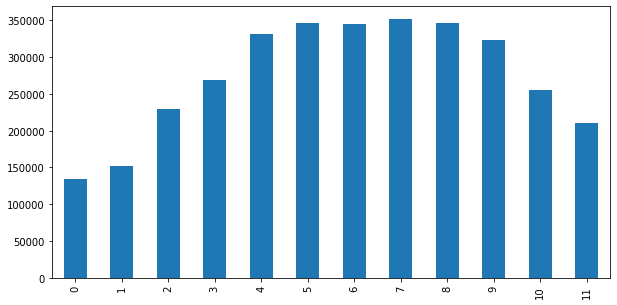

In [8]:
data_plot = data_small_df.groupby('mnth', as_index=False).agg('sum')[['mnth','cnt']]
data_plot
data_plot['cnt'].plot.bar(figsize=(10,5))


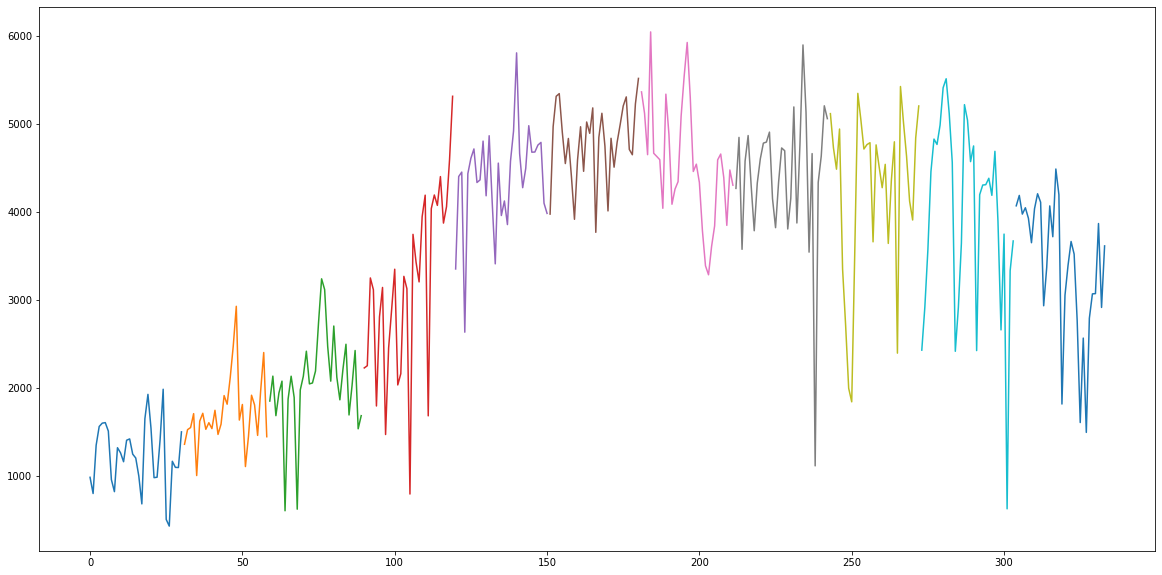

In [ ]:
data_plot_2 = data_df[['Date_dt','cnt','mnth','yr']]
data_plot_2= data_plot_2[data_plot_2['yr']==0]

for x in range(1,12):
    data_plot_2[data_plot_2['mnth']==x]['cnt'].plot(figsize=(20,10))

In [ ]:
scaler = MinMaxScaler()
data_small_df['cnt_Scaled'] = scaler.fit_transform(data_small_df[['cnt']])
data_small_df.head()

,Date_dt,cnt,mnth,cnt_Scaled
0,2011-01-01,985,1,0.110792
1,2011-01-02,801,1,0.089623
2,2011-01-03,1349,1,0.152669
3,2011-01-04,1562,1,0.177174
4,2011-01-05,1600,1,0.181546


### Traditional Embeddings

In [ ]:
pd.get_dummies(data_small_df['mnth']).head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


### Deep Encoding

In [9]:
data_small_df['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
data_small_df['mnth'] = data_small_df['mnth']-1
data_small_df['mnth'] = data_small_df['mnth'].astype(int)

In [ ]:
embedding_size = 3

model = models.Sequential()
model.add(Embedding(input_dim = 12, output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(x = data_small_df['mnth'].values, y=data_small_df['cnt_Scaled'].values , epochs = 50, batch_size = 4)


Epoch 1/50
183/183 [==============================] - 2s 4ms/step - loss: 0.0744 - accuracy: 0.0027
Epoch 2/50
183/183 [==============================] - 1s 4ms/step - loss: 0.0316 - accuracy: 0.0014
Epoch 3/50
183/183 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.0014
Epoch 4/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.0014
Epoch 5/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.0014
Epoch 6/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.0014
Epoch 7/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.0014
Epoch 8/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.0014
Epoch 9/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.0014
Epoch 10/50
183/183 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.0014

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 3)              36        
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 15)                765       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
layer = model.get_layer('embedding')
output_embeddings = layer.get_weights()
output_embeddings

[array([[-0.1723242 , -0.22398467, -0.1587686 ],
        [-0.07178074, -0.13040155, -0.1773205 ],
        [-0.06258708, -0.09314278, -0.01316557],
        [-0.01270089,  0.02225325,  0.01008021],
        [ 0.10318412,  0.07598124,  0.07703916],
        [ 0.10532589,  0.11036447,  0.1453224 ],
        [ 0.07452605,  0.10285933,  0.10971527],
        [ 0.07795038,  0.10515448,  0.1272875 ],
        [ 0.10483762,  0.09837024,  0.1518811 ],
        [ 0.03947923,  0.08773048,  0.058366  ],
        [-0.04391452,  0.00449358, -0.02005504],
        [-0.05201242, -0.10185727, -0.05493237]], dtype=float32)]

In [ ]:
output_embeddings_df = pd.DataFrame(output_embeddings[0])
output_embeddings_df = output_embeddings_df.reset_index()
output_embeddings_df.columns = ['mnth', 'embedding_1', 'embedding_2', 'embedding_3']
output_embeddings_df

,mnth,embedding_1,embedding_2,embedding_3
0,0,-0.172324,-0.223985,-0.158769
1,1,-0.071781,-0.130402,-0.177320
2,2,-0.062587,-0.093143,-0.013166
3,3,-0.012701,0.022253,0.010080
4,4,0.103184,0.075981,0.077039
5,5,0.105326,0.110364,0.145322
6,6,0.074526,0.102859,0.109715
7,7,0.077950,0.105154,0.127288
8,8,0.104838,0.098370,0.151881
9,9,0.039479,0.087730,0.058366


### Vizualisation

In [ ]:
output_embeddings_df.iloc[:,1:]

,embedding_1,embedding_2,embedding_3
0,-0.172324,-0.223985,-0.158769
1,-0.071781,-0.130402,-0.177320
2,-0.062587,-0.093143,-0.013166
3,-0.012701,0.022253,0.010080
4,0.103184,0.075981,0.077039
5,0.105326,0.110364,0.145322
6,0.074526,0.102859,0.109715
7,0.077950,0.105154,0.127288
8,0.104838,0.098370,0.151881
9,0.039479,0.087730,0.058366


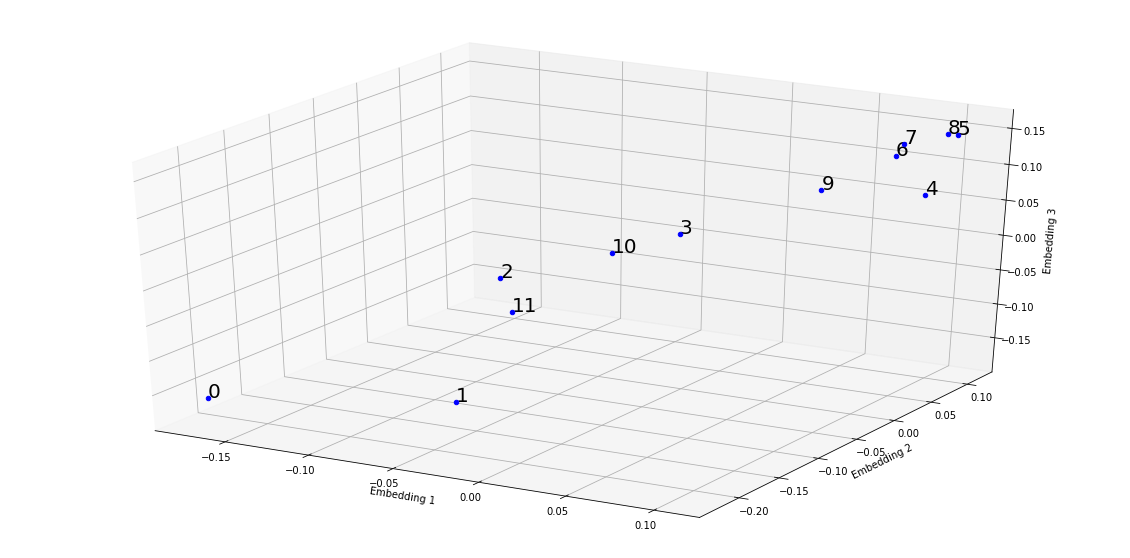

In [ ]:
m = output_embeddings_df.iloc[:,1:].values
labels = output_embeddings_df.iloc[:,0:1].values
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(labels)):
    ax.scatter(m[i,0],m[i,1],m[i,2], color='b')
    ax.text(m[i,0],m[i,1],m[i,2],'%s'%(str(labels[i][0])), size=20, zorder=1, color='k')

ax.set_xlabel('Embedding 1')  
ax.set_ylabel('Embedding 2')  
ax.set_zlabel('Embedding 3')  
plt.show()

[Table2Vec: Neural Word and Entity Embeddings for Table Population and Retrieval](https://arxiv.org/abs/1906.00041)

[GitHub Table2vec](https://github.com/ninalx/table2vec-lideng)

## Memory-efficient embeddings for recommendation systems

We will be drawing on the [embeddings tutorial](https://keras.io/examples/keras_recipes/memory_efficient_embeddings/) included in the official Keras documentation on the topic, authored by [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/).

ap### Introduction

This example demonstrates two techniques for building memory-efficient recommendation models
by reducing the size of the embedding tables, without sacrificing model effectiveness:

1. [Quotient-remainder trick](https://arxiv.org/abs/1909.02107), by Hao-Jun Michael Shi et al.,
which reduces the number of embedding vectors to store, yet produces unique embedding
vector for each item without explicit definition.
2. [Mixed Dimension embeddings](https://arxiv.org/abs/1909.11810), by Antonio Ginart et al.,
which stores embedding vectors with mixed dimensions, where less popular items have
reduced dimension embeddings.

We use the [1M version of the Movielens dataset](https://grouplens.org/datasets/movielens/1m/).
The dataset includes approximately 1 million ratings from 6,000 users on 4,000 movies.

### Setup

In [ ]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt

### Prepare the data

### Download and process data

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

ratings_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

ratings_data["movie_id"] = ratings_data["movie_id"].apply(lambda x: f"movie_{x}")
ratings_data["user_id"] = ratings_data["user_id"].apply(lambda x: f"user_{x}")
ratings_data["rating"] = ratings_data["rating"].apply(lambda x: float(x))
del ratings_data["unix_timestamp"]

print(f"Number of users: {len(ratings_data.user_id.unique())}")
print(f"Number of movies: {len(ratings_data.movie_id.unique())}")
print(f"Number of ratings: {len(ratings_data.index)}")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Number of users: 6040
Number of movies: 3706
Number of ratings: 1000209




### Create train and evaluate data splits

In [ ]:
random_selection = np.random.rand(len(ratings_data.index)) <= 0.85
train_data = ratings_data[random_selection]
eval_data = ratings_data[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
eval_data.to_csv("eval_data.csv", index=False, sep="|", header=False)
print(f"Train data split: {len(train_data.index)}")
print(f"Eval data split: {len(eval_data.index)}")
print("Train and eval data files are saved.")

Train data split: 850713
Eval data split: 149496
Train and eval data files are saved.


### Define dataset metadata and hyperparameters

In [ ]:
csv_header = list(ratings_data.columns)
user_vocabulary = list(ratings_data.user_id.unique())
movie_vocabulary = list(ratings_data.movie_id.unique())
target_feature_name = "rating"
learning_rate = 0.001
batch_size = 128
num_epochs = 3
base_embedding_dim = 64

### Train and evaluate the model

In [ ]:

def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=True):
    return tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=csv_header,
        label_name=target_feature_name,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    )


def run_experiment(model):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
    )
    # Read the training data.
    train_dataset = get_dataset_from_csv("train_data.csv", batch_size)
    # Read the test data.
    eval_dataset = get_dataset_from_csv("eval_data.csv", batch_size, shuffle=False)
    # Fit the model with the training data.
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=eval_dataset,)
    return history


### Experiment 1: baseline collaborative filtering model

#### Implement embedding encoder

In [ ]:

def embedding_encoder(vocabulary, embedding_dim, num_oov_indices=0, name=None):
    return keras.Sequential(
        [
            StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=num_oov_indices
            ),
            layers.Embedding(
                input_dim=len(vocabulary) + num_oov_indices, output_dim=embedding_dim
            ),
        ],
        name=f"{name}_embedding" if name else None,
    )


### Implement the baseline model

In [ ]:

def create_baseline_model():
    # Receive the user as an input.
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    # Get user embedding.
    user_embedding = embedding_encoder(
        vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, name="user"
    )(user_input)

    # Receive the movie as an input.
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    # Get embedding.
    movie_embedding = embedding_encoder(
        vocabulary=movie_vocabulary, embedding_dim=base_embedding_dim, name="movie"
    )(movie_input)

    # Compute dot product similarity between user and movie embeddings.
    logits = layers.Dot(axes=1, name="dot_similarity")(
        [user_embedding, movie_embedding]
    )
    # Convert to rating scale.
    prediction = keras.activations.sigmoid(logits) * 5
    # Create the model.
    model = keras.Model(
        inputs=[user_input, movie_input], outputs=prediction, name="baseline_model"
    )
    return model


baseline_model = create_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (Sequential)    (None, 64)           386560      ['user_id[0][0]']                
                                                                                                  
 movie_embedding (Sequential)   (None, 64)           237184      ['movie_id[0][0]']               
                                                                                     

Notice that the number of trainable parameters is 623,744

Epoch 1/3
6647/6647 [==============================] - 172s 26ms/step - loss: 1.1455 - mae: 0.8613 - val_loss: 0.9283 - val_mae: 0.7546
Epoch 2/3
6647/6647 [==============================] - 168s 25ms/step - loss: 0.8151 - mae: 0.7130 - val_loss: 0.7941 - val_mae: 0.7055
Epoch 3/3
6647/6647 [==============================] - 168s 25ms/step - loss: 0.7314 - mae: 0.6746 - val_loss: 0.7526 - val_mae: 0.6853


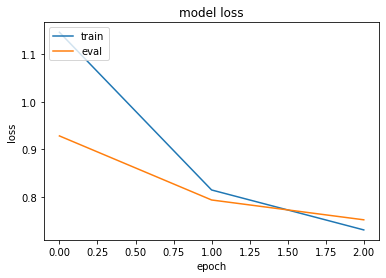

In [ ]:
history = run_experiment(baseline_model)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

### Experiment 2: memory-efficient model

### Implement Quotient-Remainder embedding as a layer

The Quotient-Remainder technique works as follows. For a set of vocabulary and  embedding size
`embedding_dim`, instead of creating a `vocabulary_size X embedding_dim` embedding table,
we create *two* `num_buckets X embedding_dim` embedding tables, where `num_buckets`
is much smaller than `vocabulary_size`.
An embedding for a given item `index` is generated via the following steps:

1. Compute the `quotient_index` as `index // num_buckets`.
2. Compute the `remainder_index` as `index % num_buckets`.
3. Lookup `quotient_embedding` from the first embedding table using `quotient_index`.
4. Lookup `remainder_embedding` from the second embedding table using `remainder_index`.
5. Return `quotient_embedding` * `remainder_embedding`.

This technique reduces the number of embedding vectors needs to be stored and trained,
but also generates a *unique* embedding vector for each item of size `embedding_dim`.
Note that `q_embedding` and `r_embedding` can be combined using other operations,
like `Add` and `Concatenate`.

In [ ]:

class QREmbedding(keras.layers.Layer):
    def __init__(self, vocabulary, embedding_dim, num_buckets, name=None):
        super(QREmbedding, self).__init__(name=name)
        self.num_buckets = num_buckets

        self.index_lookup = StringLookup(
            vocabulary=vocabulary, mask_token=None, num_oov_indices=0
        )
        self.q_embeddings = layers.Embedding(num_buckets, embedding_dim,)
        self.r_embeddings = layers.Embedding(num_buckets, embedding_dim,)

    def call(self, inputs):
        # Get the item index.
        embedding_index = self.index_lookup(inputs)
        # Get the quotient index.
        quotient_index = tf.math.floordiv(embedding_index, self.num_buckets)
        # Get the reminder index.
        remainder_index = tf.math.floormod(embedding_index, self.num_buckets)
        # Lookup the quotient_embedding using the quotient_index.
        quotient_embedding = self.q_embeddings(quotient_index)
        # Lookup the remainder_embedding using the remainder_index.
        remainder_embedding = self.r_embeddings(remainder_index)
        # Use multiplication as a combiner operation
        return quotient_embedding * remainder_embedding


### Implement Mixed Dimension embedding as a layer

In the mixed dimension embedding technique, we train embedding vectors with full dimensions
for frequently queried items, while training embedding vectors with *reduced dimensions*
for less frequent items, plus a *projection weights matrix* to bring low dimension embeddings
to full dimensions. Why? More information on the frequently queried items provides us with high resolution similarity and difference that we can appreciate even if that resolution is not available for the infrequently queried itesm--its like defining a different number of significant digits for quantities understood with greater or less certainty.

More precisely, we define *blocks* of items of similar frequencies. For each block,
a `block_vocab_size X block_embedding_dim` embedding table and `block_embedding_dim X full_embedding_dim`
projection weights matrix are created. Note that, if `block_embedding_dim` equals `full_embedding_dim`,
the projection weights matrix becomes an *identity* matrix. Embeddings for a given batch of item
`indices` are generated via the following steps:

1. For each block, lookup the `block_embedding_dim` embedding vectors using `indices`, and
project them to the `full_embedding_dim`.
2. If an item index does not belong to a given block, an out-of-vocabulary embedding is returned.
Each block will return a `batch_size X full_embedding_dim` tensor.
3. A mask is applied to the embeddings returned from each block in order to convert the
out-of-vocabulary embeddings to vector of zeros. That is, for each item in the batch,
a single non-zero embedding vector is returned from the all block embeddings.
4. Embeddings retrieved from the blocks are combined using *sum* to produce the final
`batch_size X full_embedding_dim` tensor.

In [ ]:
class MDEmbedding(keras.layers.Layer):
    def __init__(
        self, blocks_vocabulary, blocks_embedding_dims, base_embedding_dim, name=None
    ):
        super(MDEmbedding, self).__init__(name=name)
        self.num_blocks = len(blocks_vocabulary)

        # Create vocab to block lookup.
        keys = []
        values = []
        for block_idx, block_vocab in enumerate(blocks_vocabulary):
            keys.extend(block_vocab)
            values.extend([block_idx] * len(block_vocab))
        self.vocab_to_block = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys, values), default_value=-1
        )

        self.block_embedding_encoders = []
        self.block_embedding_projectors = []

        # Create block embedding encoders and projectors.
        for idx in range(self.num_blocks):
            vocabulary = blocks_vocabulary[idx]
            embedding_dim = blocks_embedding_dims[idx]
            block_embedding_encoder = embedding_encoder(
                vocabulary, embedding_dim, num_oov_indices=1
            )
            self.block_embedding_encoders.append(block_embedding_encoder)
            if embedding_dim == base_embedding_dim:
                self.block_embedding_projectors.append(layers.Lambda(lambda x: x))
            else:
                self.block_embedding_projectors.append(
                    layers.Dense(units=base_embedding_dim)
                )

    def call(self, inputs):
        # Get block index for each input item.
        block_indicies = self.vocab_to_block.lookup(inputs)
        # Initialize output embeddings to zeros.
        embeddings = tf.zeros(shape=(tf.shape(inputs)[0], base_embedding_dim))
        # Generate embeddings from blocks.
        for idx in range(self.num_blocks):
            # Lookup embeddings from the current block.
            block_embeddings = self.block_embedding_encoders[idx](inputs)
            # Project embeddings to base_embedding_dim.
            block_embeddings = self.block_embedding_projectors[idx](block_embeddings)
            # Create a mask to filter out embeddings of items that do not belong to the current block.
            mask = tf.expand_dims(tf.cast(block_indicies == idx, tf.dtypes.float32), 1)
            # Set the embeddings for the items not belonging to the current block to zeros.
            block_embeddings = block_embeddings * mask
            # Add the block embeddings to the final embeddings.
            embeddings += block_embeddings

        return embeddings


### Implement the memory-efficient model

In this experiment, we use the **Quotient-Remainder** technique to reduce the
size of the user embeddings, and the **Mixed Dimension** technique to reduce the size of the movie embeddings.

While in the associated [paper](https://arxiv.org/abs/1909.11810), an alpha-power rule is used to determined dimensions of the embedding for each block, we simply set the number of blocks and the
dimensions of embeddings of each block based on the histogram visualization of movie popularity.

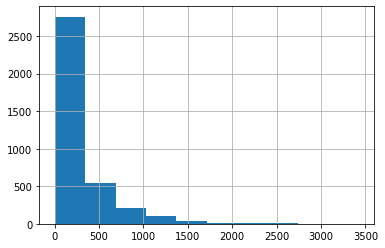

In [ ]:
movie_frequencies = ratings_data["movie_id"].value_counts()
movie_frequencies.hist(bins=10)

You can see that we can group movies into three blocks, and assign them 64, 32, and 16
embedding dimensions, respectively. Experiment with different number of blocks
and dimensions.

In [ ]:
sorted_movie_vocabulary = list(movie_frequencies.keys())

movie_blocks_vocabulary = [
    sorted_movie_vocabulary[:400],  # high popularity movies block
    sorted_movie_vocabulary[400:1700],  # normal popularity movies block
    sorted_movie_vocabulary[1700:],  # low popularity movies block
]

movie_blocks_embedding_dims = [64, 32, 16]

user_embedding_num_buckets = len(user_vocabulary) // 50

In [ ]:
def create_memory_efficient_model():
    # Take the user as an input.
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    # Get user embedding.
    user_embedding = QREmbedding(
        vocabulary=user_vocabulary,
        embedding_dim=base_embedding_dim,
        num_buckets=user_embedding_num_buckets,
        name="user_embedding",
    )(user_input)

    # Take the movie as an input.
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    # Get embedding.
    movie_embedding = MDEmbedding(
        blocks_vocabulary=movie_blocks_vocabulary,
        blocks_embedding_dims=movie_blocks_embedding_dims,
        base_embedding_dim=base_embedding_dim,
        name="movie_embedding",
    )(movie_input)

    # Compute dot product similarity between user and movie embeddings.
    logits = layers.Dot(axes=1, name="dot_similarity")(
        [user_embedding, movie_embedding]
    )
    # Convert to rating scale.
    prediction = keras.activations.sigmoid(logits) * 5
    # Create the model.
    model = keras.Model(
        inputs=[user_input, movie_input], outputs=prediction, name="baseline_model"
    )
    return model

In [ ]:
memory_efficient_model = create_memory_efficient_model()
memory_efficient_model.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (QREmbedding)   (None, 64)           15360       ['user_id[0][0]']                
                                                                                                  
 movie_embedding (MDEmbedding)  (None, 64)           102608      ['movie_id[0][0]']               
                                                                                     

Notice that the number of trainable parameters is 117,968, which is more than 5x less than
the number of parameters in the baseline model.

Epoch 1/3
6647/6647 [==============================] - 130s 19ms/step - loss: 1.0312 - mae: 0.8135 - val_loss: 1.0625 - val_mae: 0.8050
Epoch 2/3
6647/6647 [==============================] - 129s 19ms/step - loss: 0.8855 - mae: 0.7484 - val_loss: 0.8944 - val_mae: 0.7506
Epoch 3/3
6647/6647 [==============================] - 130s 20ms/step - loss: 0.8369 - mae: 0.7257 - val_loss: 0.8603 - val_mae: 0.7352


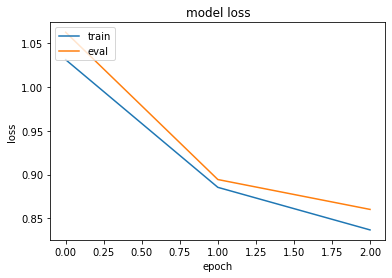

In [ ]:
history = run_experiment(memory_efficient_model)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

# TaBERT

It is possible to jointly train language models with tables to create a model which is capable of running queries over a table using the powerful deep representations of language models. Facebook Research have released a model named TaBERT which does this.

- [FB blog post](https://ai.facebook.com/blog/tabert-a-new-model-for-understanding-queries-over-tabular-data/)
- [TaBERT](https://arxiv.org/abs/2005.08314): Pretraining for Joint Understanding of Textual and Tabular Data
- [GitHub repository](https://github.com/facebookresearch/TaBERT)

**Note: TaBERT is not yet available to run on Google Colab, with multiple errors due to installation dependancies, and FB has not offered any support on using TaBERT outside of their basic code examples on the repository. We will soon provide a jupyter notebook you can run on local, with instructions, but cannot currently offer Colab support.** 


In [ ]:
# empty cell

# Knowledge Graph Embeddings

A knowledge graph (KG) is a directed heterogeneous multigraph whose node and relation types have domain-specific semantics (e.g., body parts linked by a joint or tendon; people possessing a shared characteristic). KGs allow us to encode the knowledge into a form that is human interpretable and amenable to automated analysis and inference. KGs are becoming a popular approach to represent diverse types of information in the form of different types of entities connected via different types of relations.

When working with KGs, we adopt a different terminology than the traditional vertices and edges used in graphs. The vertices of the knowledge graph are often called entities and the directed edges are often called triplets and are represented as a (h, r, t) tuple, where h is the head entity, t is the tail entity, and r is the relation associating the head with the tail entities. Note that the term relation here refers to the type of the relation (e.g., one of wants-to-buy, has-bought, is-customer-of, and is-selling). We note that this terminology may vary. For example, the RDF (resource description framework) data model draws on the language of logical inference, calling head, tail and relation as subject, object and predicate (i.e., verb). An (h,r,t) and (s,p,o) triple are the same thing. Sometimes, in linguistic settings, the p (predicate) is replaced by a v for verb, yielding an (s,v,o) triplet. 

Knowledge Graph Embeddings can then be used to learn these head, tail and relational (or s,p/v,o) entities as embeddings which can then be used for a variety of downstream tasks.

In this section, you will be following a variant of a Knowledge Graph Embeddings tutorial previously conducted at ECAI 2020, an AI conference. The tutorial uses AmpliGraph (by Accenture), which is currently the most used open source KGE package, but there are many other options:

- scikit-kge - ([blog post](https://mnick.github.io/project/knowledge-graph-embeddings/), [code](https://github.com/mnick/scikit-kge), [helper code](https://github.com/mnick/scikit-kge))

- kgetorch - ([documentation](https://torchkge.readthedocs.io/en/latest/reference/models.html), [code](https://github.com/torchkge-team/torchkge), [helper code](https://github.com/bakerwho/weboftruth/blob/master/weboftruth/utils.py))

- pykg2vec - ([documentation](https://pykg2vec.readthedocs.io/en/latest/index.html), [code](https://github.com/Sujit-O/pykg2vec)

We are working to create material and support these packages as well.



## ECAI 2020 Tutorials on KGE

<u>**Contents**</u>
- Loading a KG and creating train/test splits
- Training and evaluating a KGE Model
- Testing user hypothesis
- Early stopping and types of evaluation
- Choosing model hyperparameters
- Discovering facts using trained model
- Visualizing embeddings and Clustering


In [ ]:
# empty cell

### 1. Introduction and Preliminaries

For this hands-on tutorial, we will be using the open-source library [AmpliGraph](https://github.com/Accenture/AmpliGraph). 

Let's start by installing the library and it's dependencies, and then importing the libraries used in this tutorial. 

In [ ]:
# If running on local system execute this cell

# Install CUDA
#! conda install -y cudatoolkit=10.0

# Install cudnn libraries
# This library improves the performance of tensorflow, however, we need to give up determinism over speed.
#! conda install cudnn=7.6

# Install tensorflow GPU 
# ! pip install tensorflow-gpu==1.15.3

In [ ]:
# If using Google Colab run this cell 

# select tensorflow version for colab 
%tensorflow_version 1.x

TensorFlow 1.x selected.


Let us check if tensorflow is correctly installed and if we can access the GPU

In [ ]:
import tensorflow as tf 

print('TensorFlow  version: {}'.format(tf.__version__))

# Get the GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow  version: 1.15.2
Found GPU at: /device:GPU:0


Let's install AmpliGraph and other dependencies

In [ ]:
%%capture 
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [ ]:
# All imports used in this tutorial 
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


### 2. Loading a Knowledge Graph dataset

To begin we're going to need a knowledge graph, so let's load a standard knowledge graph called ***Freebase-15k-237***. 

Ampligraph provides a set of APIs to [load standard knowledge graphs](https://docs.ampligraph.org/en/1.3.1/ampligraph.datasets.html#benchmark-datasets-loaders). 

Also provided are a set of APIs load csv, ntriples and rdf formats. Details can be found [here](https://docs.ampligraph.org/en/1.3.1/ampligraph.datasets.html#loaders-for-custom-knowledge-graphs)


In [ ]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10


For this tutorial we have remapped the IDs of freebase 237 and created a csv file containing human readable names instead of IDs. 

In [ ]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


In [ ]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (310079, 3)



![KG](https://user-images.githubusercontent.com/39597669/90747195-9fc44c80-e2c8-11ea-9f70-097993581bac.png) 



### 2.1 Create training, validation and test splits

Let's use the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/1.3.1/generated/ampligraph.evaluation.train_test_split_no_unseen.html?#train-test-split-no-unseen) function provided by Ampligraph to create the training, validation and test splits. 

This API ensures that the test and validation splits contains triples whose entities are "seen" during training. 


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (310079, 3)
Size of train: (308579, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


###**Key Takeaways**

- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training

### 3. Model Training
Now that we have split the dataset, let's dive directly into model training. 

Let us create a TransE model and train it on the training split using the `fit` function.

**TransE** is one of the first embedding models which set the platform for the KGE research. It is an energy-based model for learning entity embeddings such that relationships are represented as translations in the embedding space: if $(s, p, o)$ holds, then the embedding of the
object entity o should be close to the embedding of the subject entity $s$ plus some vector that depends on the predicate $p$. TransE has a very low number of trainable parameters compared to most modelsIn and uses simple vector algebra to score triples: 

$Score=||s+p-o||_n$

In [ ]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE-small.pkl')

Average TransE Loss:   0.013551: 100%|██████████| 100/100 [00:10<00:00, 10.00epoch/s]


You can refer [this link](https://docs.ampligraph.org/en/latest/api.html) for detailed explaination of the parameters and their values.

### 3.1 Compute the evaluation metrics

### Per triple metrics:
This is a metric computed for each test set triple:

- **score**: This is the value assigned to a triple, by the model, by applying the scoring function.

Let's look at how we can get the score for a triple of interest and how to interpret it.


In [ ]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.411186]


But what does this score tell you? Nothing! It is just a value. In order to interpret the score we have 2 options:

1. We can create a list of hypotheses that we want to test, score them and then choose the top $n$ hypotheses as True statements.

2. Unlike a classification task, we are doing a learning to rank task. In order to interpret the score we can generate the corruptions and compare the triple score against the scores of corruptions to see how well the model ranks the test triple against them.

Let's look at the first option, create a list of hypotheses and score them.

In [ ]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill', 'neil patrick harris', 'harrison ford' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.411186'],
       ['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.487747'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-8.995587'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.21589'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.554007'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.60973'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-9.63883']], dtype='<U39')


- **rank**: For a triple, this metric is computed by generating corruptions (random triples) and then scoring them and computing the rank(position) of the triple score against the corruptions. The pseudocode and the example illustrates how to compute rank on the test set.

         for each test set triple <h, r, t>:
                 a. Compute the score of the test triple (hypothesis) 
                     hypothesis_score = score(<h, r, t>)
                     
                 b. Generate the subject corruptions 
                         sub_corr = <?, r, t>
                 c. Compute the score of the subject corruptions
                         sub_corr_score = score(sub_corr) 
                 d. Find the position of hypothesis_score in sub_corr_score to get the sub_rank
                   
                 e. Generate the object corruption 
                         obj_corr = <h, r, ?>
                 f. Compute the score of the object corruptions
                         obj_corr_score = score(obj_corr) 
                 g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
                 
                 h. Return rank = [sub_rank, obj_rank]



![rank example](https://user-images.githubusercontent.com/281477/90627614-14897f00-e214-11ea-8f8e-d57da9888606.png)





### Illustrative Example 

**Compute the score of the test triple**

In [ ]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.411186]


Before generating the corruptions, let us look at the number of unique entities present in our dataset

In [ ]:
print('The number of unique entities:', len(model.ent_to_idx))

The number of unique entities: 14184


**Generate the subject *corruptions* and compute rank**
> ```sub_corr = <?, r, t>```

In [ ]:

subj_corr =  np.column_stack([list(model.ent_to_idx.keys()),
                [test_triple[1]] * len(model.ent_to_idx), 
                [test_triple[2]] * len(model.ent_to_idx)])

print('Subject corruptions:\n', subj_corr)
print('\nSize of subject corruptions:\n', subj_corr.shape)

Subject corruptions:
 [['/m/011xg5' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yd2' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yxg' '/film/actor/film./film/performance/film' 'star wars']
 ...
 ['zoology' '/film/actor/film./film/performance/film' 'star wars']
 ['zurich' '/film/actor/film./film/performance/film' 'star wars']
 ['zz top' '/film/actor/film./film/performance/film' 'star wars']]

Size of subject corruptions:
 (14184, 3)


**Compute the score of the subject corruptions**

In [ ]:
sub_corr_score = model.predict(subj_corr)

Now that we have a score, let us compute the rank as follows:

<center>$COUNT ( corruption_{score} >= triple_{score} )$</center>

Find the position of hypothesis_score in sub_corr_score to get the sub_rank

In [ ]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1

print('Assigning the worst rank (to break ties):', sub_rank_worst)

Assigning the worst rank (to break ties): 1687


**Generate the object *corruptions* and compute rank**

>    ``` obj_corr = <h, r, ?> ```


In [ ]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                     list(model.ent_to_idx.keys())])


print('Object corruptions:\n', obj_corr)
print('\nSize of object corruptions:\n', obj_corr.shape)

# f. Compute the score of the object corruptions
obj_corr_score = model.predict(obj_corr)

# g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Assigning the worst rank (to break ties):', obj_rank_worst)


Object corruptions:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Size of object corruptions:
 (14184, 3)
Assigning the worst rank (to break ties): 821


In [ ]:
print('Subject corruption rank:', sub_rank_worst)
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1687
Object corruption rank: 821


**Computing the (Unfiltered) rank using evaluate_performance API**

We can use the [evaluate_performance](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html) API to compute ranks. By default, `evaluate_performance` API computes the unfiltered ranks i.e. if any true positives are present in corruptions, they will not be removed before ranking. However, usually for evaluation, we follow a filtered evaluation as described in the next section.


In [ ]:
from ampligraph.evaluation import evaluate_performance 

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst')

print('\nRanks:', ranks)

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Ranks: [[1687  821]]


There are multiple strategies to compute ranks especially when there are ties. Lets look at each in detail with an example. 

Assume there are only 10 corruptions, and assume that all the corruptions get the same score as the test triple. The ranks are as follows 
- Assign the **worst rank** i.e. the test set triple gets a rank of 11. This is followed by most papers in the literature. This is the strictest approach and it drives down the mrr by a large margin if there are many ties. We employ this strategy in AmpliGraph.

<center> $rank = COUNT( corruption_{score} \ge hypothesis_{score} )$ + 1</center>
    
- Assign the **middle rank** i.e. the test set triple gets a rank of 6. We found this strategy being used by [ICLR 2020 paper](https://openreview.net/pdf?id=BkxSmlBFvr). This approach seems to be fair towards the model in resolving the ties as it assigns the middle rank to break ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} ) + \dfrac{COUNT( corruption_{score} == hypothesis_{score} )}{2}$ + 1</center>

- Assign the **best rank** i.e. the test set triple gets a rank of 1. This approach is followed by [ConvKB paper](https://arxiv.org/pdf/1712.02121.pdf).  This approach is overly biased and helps the model achieve a very good mrr in case of ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} )$ + 1</center>

We recommend the usage of the **worst** strategy (default).

### 3.2 Filtered evaluation
While evaluating ([as described earlier](#Compute-the-evaluation-metrics)), we generate all corruptions (using all unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some corruptions may not really be corruptions and may be ground truth triples observed during training. Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all the True Positive triples  to `filter_triples` parameter of the `evaluate_performance` API. This will perform a **"filtered" evaluation** and return the **"filtered" ranks** adjusted by removing the True Positives from the corruptions. More details for `evaluate_performance` API can be found [here](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html#ampligraph.evaluation.evaluate_performance).


In [ ]:
from ampligraph.evaluation import evaluate_performance 

print('Size of X_test:', X_test.shape)

X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             filter_triples=X_filter)

print(ranks)

Size of X_test: (1000, 3)


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


[[1677  811]]


One obvious question is why do we append the Valid and Test set to the X_filter. The model has not "observed" them during training. We do so because, we would like to evaluate a test triple against it's corruptions and not against known facts. If we know that the Validation triples and Test triples are facts (and not queries), we need to filter these triples out of the generated corruptions. This is the standard procedure that is used to compute the metrics to compete on the leadership board.

### 3.3 Aggregate metrics


Once we have the ranks for all test set triples, we can compute the following aggregate metrics: **MR**, **MRR**, **Hits@N**, which indicate overall quality of the model on a test set. These metrics come from Information Retrieval domain and are always computed on a set of **True Statements**. To illustrate each of these metric let us first create a small test set of 5 triples and compute their ranks.

In [ ]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],

                ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['star wars', '/film/film/language', 'english language'],
                ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']])


X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small, 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
print(ranks)

100%|██████████| 5/5 [00:00<00:00, 34.23it/s]


[[   8    6]
 [   2    1]
 [  90    1]
 [   1    1]
 [1677  811]]


Now let us look at each aggregate metrics in detail:

- **Mean rank (MR)**, as the name indicates, is the average of all the ranks of the triples. The value ranges from 1 (ideal case when all ranks equal to 1) to number of corruptions (where all the ranks are last).

$MR=\frac{1}{|Q|}\sum^{|Q|}_{i=1}rank_{(h,r,t)_i}$

In [ ]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 259.8


- **Mean reciprocal rank (MRR)**, is the average of the reciprocal ranks of all the triples. The value ranges from 0 to 1; higher the value better is the model.

$MRR=\frac{1}{|Q|}\sum^{|Q|}_{i=1}\frac{1}{rank_{(h,r,t)_i}}$

In [ ]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.480460712632235


MRR is an indicator of mean rank after removing the effect of outliers.

In [ ]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  3.0


- **hits@n** is the percentage of computed ranks greater than or equal to a rank of $n$. The value ranges from 0 to 1; higher the value better is the model.

$Hits@N=\frac{1}{|Q|}\sum^{|Q|}_{i=1} 1 \text{ if } rank_{(h,r,t)_i}\le N$

In [ ]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.4
hits@10 : 0.7


In [ ]:
# print unique entities
print('Number of unique entities:', len(model.ent_to_idx))

Number of unique entities: 14184


**What if, for a model, you observe that on a test set, the MRR score is 0.01? Is it a good model?**

This is not straightforward. What the above value means is that if you remove the outlier effect, on average the ranks are approximately 100 (1/0.01). It may be a good/bad value. It depends on number of corruptions you have used for the computation. If you had 1 million corruptions and yet the mrr score was 0.01, the model is not bad as on average it gave a rank of close to 100. But say if the corruptions were only 100 and we had an mrr of 0.01, it means that the model did a very bad (the worst) job at ranking the test triples against just 100 corruptions.

On a real dataset, on should take a closer look at **hits@n** values to decide whether the model is strong. ***The choice of n should depend on the number of corruptions being generated per test triple***. If a large percentage of ranks computed on the test set triple falls within the $n$ ranks, then the model can be considered as a good model.

In [ ]:

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))


display_aggregate_metrics(ranks)


Mean Rank: 259.8
Mean Reciprocal Rank: 0.480460712632235
Hits@1: 0.4
Hits@10: 0.7
Hits@100: 0.8



### 3.4. Training with early stopping

While training a model, we would like to make sure that the model does not over or under fit on the data. If we train a model for a fixed number of epochs, we will not know whether the model has underfit. Hence it is necessary to test the model performance on a held out set at regular intervals to decide when to stop training. This is called "Early stopping", i.e. we don't let the model run for a long time but stop much before when performance on the held out set starts to degrade. 

However we also do not want to model to overfit on the held out set and limit the generalization capabilities of the model. Hence we should create both a validation set and a test set to verify the generalization capability of the model. 

In [ ]:

early_stopping_params = { 'x_valid': X_valid,   # Validation set on which early stopping will be performed
                          'criteria': 'mrr',    # metric to watch during early stopping
                          'burn_in': 150,       # Burn in time, i.e. early stopping checks will not be performed till 150 epochs
                          'check_interval': 50, # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
                          'stop_interval': 2,   # If the monitored criteria degrades for these many epochs, the training stops. 
                          'corrupt_side':'s,o'  # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
                        }

# create a model as earlier
model = TransE(k=100, 
               epochs=10000, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

# call model.fit by passing early stopping params
model.fit(X_train,                                      # training set
          early_stopping=True,                          # set early stopping to true
          early_stopping_params=early_stopping_params)  # pass the early stopping params

# evaluate the model with filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)
# display the metrics
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


Average TransE Loss:   0.016593 — Best validation (mrr): 0.092176:   7%|▋         | 699/10000 [00:32<07:06, 21.79epoch/s]
100%|██████████| 1000/1000 [00:03<00:00, 260.06it/s]


Mean Rank: 498.688
Mean Reciprocal Rank: 0.1646466463078662
Hits@1: 0.1025
Hits@10: 0.28
Hits@100: 0.592



### Summary so far


In [ ]:
# ----------------------
# Generate train/test data
# create train/test/valid splits, train the model and evaluate using train_test_split_no_unseen API
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)
# ----------------------
# Training:

print('Training set:', X_train.shape)

# Train a KGE model
model = TransE(k=300, 
               epochs=100, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.0001}, 
               seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)
# ----------------------
# Evaluate: 
# Filtered evaluation with ranking strategy assigning worst rank to break ties

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE.pkl')
model = restore_model('TransE.pkl')

# create the filter 
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)
# ----------------------

Training set: (308579, 3)


100%|██████████| 1000/1000 [00:07<00:00, 132.53it/s]


Test set: (1000, 3)
Size of ranks: (1000, 2)
Mean Rank: 629.297
Mean Reciprocal Rank: 0.17627541706517372
Hits@1: 0.114
Hits@10: 0.294
Hits@100: 0.5555


###**Key Takeaways**
- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training
- Once a model is trained, one can use `model.predict` to choose from a set of hypothesis based on the scores returned by the model.
- One can access the quality of model on a **test set of True Facts** by using metrics such as MR, MRR and hits@n
- We can use early stopping to prevent model from over/under fitting by using a Validation Set.

### 4. Practical evaluation protocols

Standard protocols, as described earlier, follow a very strict way of evaluating the test set. We corrupt both the subject and object sides with all the entities present in the KG. Also, when the KG is huge with millions of entities, the standard protocol is not feisible. Due to the large number of corruptions, some of which may be semantically incorrect, it becomes a difficult task for the model while ranking and it may lead to misleading metrics. Hence the standard protocol is not recommended for large KGs. 

Let's now look at some practical ways of evaluating for large KGs.

### 4.1 Evaluating by corrupting specific sides
Let's assume that our test set is made up of triples of type <movie, film_language, language_category> and we want to find if our model can correctly find the language of the movie.

In [ ]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['the mummy returns', '/film/film/language', 'english language'],
       ['love affair', '/film/film/language', 'english language'],
       ['vicky cristina barcelona', '/film/film/language',
        'spanish language'],
       ['borat', '/film/film/language', 'english language'],
       ['/m/03gyvwg', '/film/film/language', 'japanese language'],
       ['and the band played on', '/film/film/language',
        'english language'],
       ['/m/09gb_4p', '/film/film/language', 'english language'],
       ['from russia with love', '/film/film/language',
        'turkish language'],
       ['titanic', '/film/film/language', 'italian language'],
       ['salt', '/film/film/language', 'english language'],
       ['superman ii', '/film/film/language', 'english language'],
       ['spy game', '/film/film/language', 'english language']],
      dtype=object)

With the evaluation shown below, we are using all entities in our dataset and corrupting both subject and object sides of the test triple and returning 2 ranks.

In [ ]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████| 12/12 [00:00<00:00, 86.29it/s]


Mean Rank: 310.75
Mean Reciprocal Rank: 0.3894430638319825
Hits@1: 0.2916666666666667
Hits@10: 0.5833333333333334
Hits@100: 0.75

Size of test set: (12, 3)
Size of ranks: (12, 2)


This is because [evaluate performance](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html#ampligraph.evaluation.evaluate_performance) with default protocol does the following:
- computes rank by corrupting the subject side (`'s'`) 
- computes rank by corrupting the object side (`'o'`) 
- returns both the ranks per triple.

The metrics (such as mrr, mr, hits@n) are computed by flattening and averaging the ranks.

This is the standard protocol that is usually followed while doing graph completion and is usually adopted for computing the metrics (on traditional datasets like freebase or wordnet) while competing on the leadership board.

If we want to corrupt specific sides (to suit our use-case), we can do so by passing `corrupt_side` parameter to `evaluate_performance`. It can take on the following values:
- `s` for subject corruption only
- `o` for object corruption only
- `s+o` for subject and object corruption. Returns a single rank.
- `s,o` for subject and object corruption separately (default). Returns 2 ranks. This is equivalent to calling `evaluate_performance` twice with `s` and `o`.


In [ ]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████| 12/12 [00:00<00:00, 103.37it/s]


Mean Rank: 6.083333333333333
Mean Reciprocal Rank: 0.6005952380952381
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0

Size of test set: (12, 3)
Size of ranks: (12,)


As you see, only 1 rank is returned per triple, and this rank is the rank obtained by corrupting only the specified side with all the entities in the KG.

### 4.2 Evaluating against a subset of entities

Depending on the use case or size of the graph, you may want to evaluate the test set by generating corruptions only from a subset of entities. This can be done by using `entities_subset` argument. For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities, etc. Say we want to find out what mutations cause disease i.e. `< ?, causes, disease_name>`. For this use case it doesn't make sense to replace the placeholder with all entities. A logical replacement would involve using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [ ]:
print('The number of corruptions generated per triple is:', len(model.ent_to_idx))

The number of corruptions generated per triple is: 14184


In [ ]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'danish language', 'finnish language', 'tamil language', 'czech language', 'latin language', 'turkish language', 'urdu language', 'portuguese language', 'hebrew language', 'american english', 'vietnamese language', 'arabic language', 'croatian language', 'japanese language', 'greek language', 'cantonese', 'bengali language', 'england', 'standard chinese', 'russian language', 'welsh language', 'yue chinese', 'yiddish language', 'malay language', 'bulgarian language', 'chinese language', 'indonesian language', 'swahili language', 'punjabi language', 'albanian language', 'ukrainian language', 'italian language', 'sinhala language', 'afrikaans language', 'spanish language', 'serbian language', 'french', 'mandarin chinese', 'filipino language', 'german food', 'khmer language', 'dutch language', 'norwegian language', 'swedish language', 'thai language', 'gujarati language', 'serbo-croatian language', 'silent film', 'persian language', 'korean language', 'taga

In [ ]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

/usr/local/lib/python3.7/dist-packages/ampligraph/latent_features/models/EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████| 12/12 [00:00<00:00, 94.04it/s]


Mean Rank: 5.916666666666667
Mean Reciprocal Rank: 0.6006944444444444
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer **semantically "valid" corruptions**. 

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would  recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation. 

###**Key Takeaways**
- During default evaluation, the `evaluate_performance` API corrupts both subject and object side with ALL the entities in the KG and returns 2 ranks. This is a hard task for the model and the resulting metrics may mislead the user. 
- Depending on use case, we can corrupt specific sides of the triples by specifying the `corrupt_side` argument; and we can also provide semantically valid entities to be used for generating corruptions by using the `entities_subset` argument in `evaluate_performance` API



### 5. Comparision of Models

In [ ]:
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB

### 5.1 Traditional models :

These models take as input vector representation of embeddings of entities and predicates of a triple. The embeddings are combined using a scoring function to generate a score. Ranking protocol is followed to train/evaluate the model.

#### TransE
As described above, TransE is one of the first embedding models that set the platform for KGE research. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. Sometimes subject, predicate, and object are used to replace head, relation, and tail.

<center>$f = - || s + p - o ||_{n}$</center>


In [ ]:
model = TransE(k=150, epochs=50, eta=1, loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:04<00:00, 247.96it/s]


Mean Rank: 975.3305
Mean Reciprocal Rank: 0.1271885486934672
Hits@1: 0.078
Hits@10: 0.226
Hits@100: 0.5085


In [ ]:
print('The number of unique entities:', len(model.ent_to_idx))
print('The number of unique relations:', len(model.rel_to_idx))

The number of unique entities: 14184
The number of unique relations: 237


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


#### DistMult
Similar to TransE, but instead of additive operations, it does multiplication of vectors to compute the score. DistMult also has same number of parameters as TransE. This model is **quite bad at differenciating anti-symmetric relations** (especially during knowledge discovery), because <s,p,o> and <o,p,s> would get the same score.

<center>$f = \sum s * p * o$</center>

Example: \< Jack Likes VideoGames \> \< VideoGames Likes Jack \>

In [ ]:
model = DistMult(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:03<00:00, 253.28it/s]


Mean Rank: 712.518
Mean Reciprocal Rank: 0.22716552824188782
Hits@1: 0.1575
Hits@10: 0.3545
Hits@100: 0.587


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


####ComplEx
This model can be thought of as performing DistMult like operations but in Complex space. The number of parameters is twice as that of TransE and DistMult (k for real part and k for imaginary part). The scoring function can handle symmetry and anti-symmetry quite well.

In [ ]:
model = ComplEx(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:05<00:00, 193.01it/s]


Mean Rank: 598.6655
Mean Reciprocal Rank: 0.22117991371706924
Hits@1: 0.155
Hits@10: 0.3515
Hits@100: 0.6055


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 300)
Size of entity embeddings: (237, 300)


#### HolE

Holographic embeddings (HOLE) are another approach to learn compositional
vector space representations of knowledge graphs. It relates to holographic models of associative memory in that it employs circular correlation to create
compositional representations. Note that circular correlation is useful for periodic data (e.g., sales volume - days of the week are periodic with shifts of 7 days; wind probability distribution - rotations by 2𝜋 give identical results, so it’s periodic in direction). There are computational advantages to circular correlation as well, which can be computed directly and very efficiently by Fourier transforms. By using correlation as the
compositional operator, HOLE can capture rich interactions
but simultaneously remains efficient to compute, easy to train,
and scalable to large datasets.

In [ ]:
model = HolE(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:05<00:00, 198.04it/s]


Mean Rank: 637.4505
Mean Reciprocal Rank: 0.21405610381219006
Hits@1: 0.15
Hits@10: 0.343
Hits@100: 0.5935


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 300)
Size of entity embeddings: (237, 300)


### 5.2 Convolutional models

These are convolutional models. They converts embeddings to an "image" like representation, and performs convolutions on them. Instead of embedding vectors(for s, p and o) as inputs to the model, you can think of the inputs to be like a 2 or 3-channel image where each channel represents s, p and o features.

Both models are similar in terms of their architecture, that is while extracting feature representation of inputs; but the main difference lies in the way in which the corruptions are generated and how the loss is computed. 


#### ConvKB

ConvKB generates **eta** or $\eta$ corruptions per training triple and computes feature matrix for the triples/corruptions (s,p,o) using shared layers. It uses margin based losses like other KGE models. 

In [ ]:
model = ConvKB(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, 
                batches_count= 5, # Goes OOM (ResourceExhaustedError) if batch count is 1
                verbose=True)


model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████| 1000/1000 [00:16<00:00, 62.43it/s]


Mean Rank: 3620.5835
Mean Reciprocal Rank: 0.04084208488886708
Hits@1: 0.026
Hits@10: 0.0665
Hits@100: 0.1375


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


####ConvE
ConvE does a "target" prediction. It uses s and p embeddings and tries to predict all the o's (multi-hot encoding) in the graph. In one way, it is equivalent to treating all the unknown entities during training as a negative. Due to this approach, one needs to use the standard "target-based" losses for training ConvE models.

The output layer of ConvE is extremely large (because it is equal to the number of unique entities in the graph), which in turn results in scalability issues when working with practical graphs.

In [ ]:
model = ConvE(k=150, epochs=2, loss='bce', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 20, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Average Loss: 585.614348: 100%|██████████| 2/2 [00:06<00:00,  3.02s/epoch]


Mapping set data: test
Mapping set data: filter


100%|██████████| 1000/1000 [00:02<00:00, 489.43it/s]


Mean Rank: 6506.092
Mean Reciprocal Rank: 0.0006113891863091853
Hits@1: 0.0
Hits@10: 0.0
Hits@100: 0.004


In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


###**Key Takeaways**
- Traditional models use the vector representation of embeddings as inputs, where as Convolutional models use image-like representations and perform convolutions on them.
- Convolutional models are extremely good when it comes to performance on standard datasets, however they don't scale well as the dataset size increases.
- ComplEx model uses 2*k embeddings internally (for real and imaginary parts)

### 6. Hyperparameter Selection


### 6.1 Role of Hyperparameters

A large value of ***k*** may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU.

In [ ]:
from ampligraph.latent_features import TransE

model = TransE(k=1000, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:00<00:00, 155.17it/s]


Mean Rank: 622.45
Mean Reciprocal Rank: 0.1518957241843961
Hits@1: 0.08
Hits@10: 0.285
Hits@100: 0.53


A small ***k*** may result in underfitting.

In [ ]:
model = TransE(k=10, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:00<00:00, 227.12it/s]


Mean Rank: 977.11
Mean Reciprocal Rank: 0.10120320293645028
Hits@1: 0.055
Hits@10: 0.205
Hits@100: 0.435


Ideally, you should choose a ***k*** which is large enough, along with a proper choice of ***eta*** or $\eta$. 

It has been observed that the performance of model increases with increase in ***eta*** up to a certain point and then saturates. Usually a good value for eta is between 20-30. [add reference]()

In [ ]:
model = TransE(k=250, epochs=20, eta=20, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:00<00:00, 204.91it/s]


Mean Rank: 580.81
Mean Reciprocal Rank: 0.1549268500636737
Hits@1: 0.09
Hits@10: 0.275
Hits@100: 0.58



### 6.2 Grid Search and Random Search

Ampligraph provides an API to perform model selection and to run experimental campaigns on datasets. One can use [select_best_model_ranking](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.select_best_model_ranking.html) to perform model selection. It supports grid search and random search.


In [ ]:
from ampligraph.evaluation import select_best_model_ranking

model_class = TransE
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [50],
                     "k": [150, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         "lr": 0.001 #lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": False
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class, 
                          X_train, 
                          X_valid, 
                          X_test, 
                          param_grid,
                          # max_combinations=2, # performs random search-executes 2 models by randomly choosing params
                          use_filter=True, 
                          verbose=True,
                          early_stopping=True)

4it [00:43, 10.88s/it]


In [ ]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.178098857660958


In [ ]:
# params of the best model
best_params

{'batches_count': 5,
 'epochs': 50,
 'eta': 1,
 'k': 150,
 'loss': 'multiclass_nll',
 'optimizer': 'adam',
 'optimizer_params': {'lr': 0.001},
 'regularizer': 'LP',
 'regularizer_params': {'lambda': 0.001, 'p': 3},
 'seed': 0,
 'verbose': False}

You can also look at the experimental history and check the various combinations tested during the model selection, along with the results for each combination, using the experimental history.

In [ ]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 1,
   'k': 150,
   'loss': 'multiclass_nll',
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.001},
   'regularizer': 'LP',
   'regularizer_params': {'lambda': 0.001, 'p': 3},
   'seed': 0,
   'verbose': False},
  'results': {'hits_1': 0.114,
   'hits_10': 0.304,
   'hits_3': 0.195,
   'mr': 498.017,
   'mrr': 0.178098857660958}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 5,
   'k': 150,
   'loss': 'multiclass_nll',
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.001},
   'regularizer': 'LP',
   'regularizer_params': {'lambda': 0.001, 'p': 3},
   'seed': 0,
   'verbose': False},
  'results': {'hits_1': 0.107,
   'hits_10': 0.31,
   'hits_3': 0.194,
   'mr': 511.88,
   'mrr': 0.17608551297098796}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 1,
   'k': 50,
   'loss': 'multiclass_nll',


###**Key Takeaways**
- Large value of k may increase the model performance slightly, however it may result in OOM on GPU and it will need larger storage space on disk.
- A small k would result in model underfitting the data
- Ideal option is to choose an "in-between" k and an appropriate value for eta. A good choice will result is similar mrr as that obtained with larger k.
- Rather than running multiple models manually for hyperparameter selection, one can use the `select_best_model_ranking` API provided by AmpliGraph to do model selection using either grid search or random search.
- You can use a callable in the search param grid and specify `max_combinations` parameter in the `select_best_model_ranking` API. AmpliGraph will perform random search, by randomly choosing values from the callable. It will evaluate `max_combinations` number of models and return the best one.

### 7. Model Calibration

In [ ]:
model = restore_model('TransE.pkl')
X_test_small = np.array([['star wars', '/film/film/language', 'english language'],
                         ['star wars', '/film/film/language', 'java']]) 

model.predict(X_test_small)

array([ -5.6359477, -11.73115  ], dtype=float32)

As described earlier, model.predict returns a score that doesn't signify anything because the score is not bound for most models. It is just a value and to interpret it we use the ranking protocol.

However, one can also [calibrate](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.EmbeddingModel.html?#ampligraph.latent_features.EmbeddingModel.calibrate) the scores of a model, so that one can obtain a bounded confidence estimate ranging from 0 to 1. This is done by performing a logistic regression on the score of triples. One can use the `calibrate` API to do this. It takes an argument `X_Pos` which should be True Positives (Eg. training set). If a list of True Negatives are available, then this can be passed to `X_Neg`. The model would calibrate the scores by tuning a logistic regressor. One can then use `predict_proba` API to get a bounded score. 

If a list of True Negatives are not available, then the calibration can be performed on synthetic corruptions. However, while doing so, one must pass the `positive_base_rate` argument which specifies the base rate of positive statements. Choosing this value is a challenging task and it affects the value predicted by `predict_proba`.



In [ ]:
model.calibrate(X_train, 
                X_neg=None, 
                positive_base_rate=0.5, 
                batches_count=100, 
                epochs=100)

Calibration Loss:   0.392433: 100%|██████████| 100/100 [00:27<00:00,  3.68epoch/s]


In [ ]:
model.predict_proba(X_test_small)

array([0.9700419, 0.2735039], dtype=float32)

For more details on calibration refer [this paper](https://arxiv.org/abs/1912.10000).

**Key Takeaways:**
- Models usually return a score between +inf and -inf (depending on the type). These scores can be calibrated to the range [0, 1] using `model.calibrate`

### 8. Knowledge Discovery 

In Ampligraph we provide a number of high-level convenience functions for performing knowledge discovery using graph embeddings:

> ***query_topn***: which when given two elements of a triple will return the top_n results of all possible completions ordered by predicted score.

> ***discover_facts***: generate a set of candidate statements using one of several defined strategies and return triples that perform well when evaluated against corruptions.

> ***find_clusters***: perform link-based cluster analysis on graph embeddings.

> ***find_duplicates***: which will find duplicate entities in a graph based on their embeddings.



### 8.1 Triple completion

Sometimes you may have either a relation and entity (head or tail) pair, or just two entities, and you want to see what the top n results returned by the model are that completes the triple. 

``` 
    <head, relation, ?> 
    <head, ?,        tail>
    <?,    relation, tail>
```

Specify ```rels_to_consider``` or ```ents_to_consider``` lists to return triples where the missing element is filled only from that list. 


In [ ]:
from ampligraph.discovery import query_topn

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

triples, scores = query_topn(model, top_n=10, 
                             head='missy elliott', 
                             relation='/people/person/profession', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -9.849929809570312 	 ['missy elliott' '/people/person/profession' 'pianist'] 
Score: -9.871614456176758 	 ['missy elliott' '/people/person/profession' 'songwriter'] 
Score: -10.250166893005371 	 ['missy elliott' '/people/person/profession' 'bandleader'] 
Score: -10.326056480407715 	 ['missy elliott' '/people/person/profession' 'record producer'] 
Score: -10.333597183227539 	 ['missy elliott' '/people/person/profession' 'musician'] 
Score: -10.365818977355957 	 ['missy elliott' '/people/person/profession' 'singer-songwriter'] 
Score: -10.431962966918945 	 ['missy elliott' '/people/person/profession' 'presenter'] 
Score: -10.454360961914062 	 ['missy elliott' '/people/person/profession' 'poet'] 
Score: -10.455535888671875 	 ['missy elliott' '/people/person/profession' 'composer'] 
Score: -10.49730110168457 	 ['missy elliott' '/people/person/profession' 'model'] 


In [ ]:

triples, scores = query_topn(model, top_n=10, 
                             head='the departed', 
                             relation=None, 
                             tail='/m/086k8', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -7.128971099853516 	 ['the departed' '/film/film/production_companies' '/m/086k8'] 
Score: -7.380791187286377 	 ['the departed'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 '/m/086k8'] 
Score: -7.616968154907227 	 ['the departed' '/location/hud_county_place/place' '/m/086k8'] 
Score: -7.776998043060303 	 ['the departed' '/education/educational_institution/campuses' '/m/086k8'] 
Score: -7.868991851806641 	 ['the departed'
 '/education/educational_institution_campus/educational_institution'
 '/m/086k8'] 
Score: -8.215829849243164 	 ['the departed' '/film/film/produced_by' '/m/086k8'] 
Score: -8.289680480957031 	 ['the departed' '/film/film/written_by' '/m/086k8'] 
Score: -8.328374862670898 	 ['the departed'
 '/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity'
 '/m/086k8'] 
Score: -8.477277755737305 	 ['the departed'
 '/award/award_nominated_work/award_nominations./award/award_nomination/nominated_for'
 '/m/086k8'] 


### 8.2 Clustering

Once the model is trained, we can use the embeddings and perform downstream tasks like clustering or classification. Here we will illustrate how to do node clustering. Ampligraph provides an api [find_clusters](https://docs.ampligraph.org/en/latest/generated/ampligraph.discovery.find_clusters.html) which takes in model, the concepts to cluster, and the clustering model (sklearn based). It performs clustering and returns the cluster indices for the concepts.

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('Size of the subset being used for subset generation:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

Size of the subset being used for subset generation: 14184


Now that we have cluster assignments, let us plot it in a 2D space. Let us use PCA to reduce the dimensions of the embeddings from k=150 to 2 dimensions.

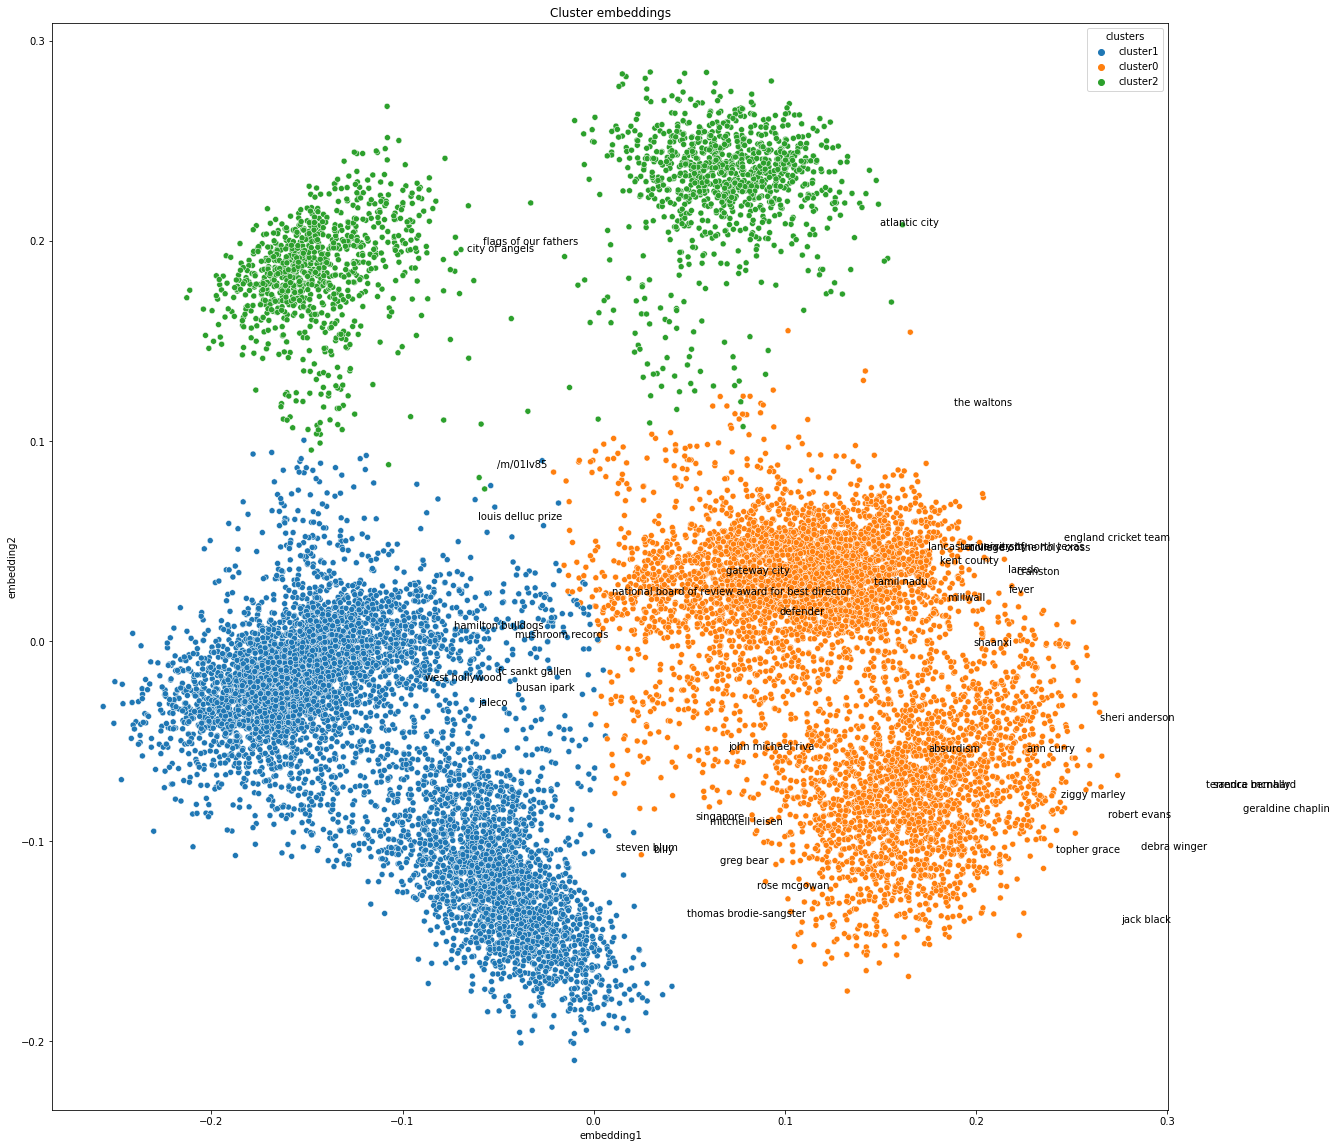

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
# from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.003:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
# adjust_text(texts)
plt.show()

### 8.3 Hypothesis Generation

Other times you may wish to discover **any** potential new facts from an existing knowledge graph. 

With a knowledge graph containing millions of entities the space of possible facts is huge, and evaluating all of them can take a very long time. In order to speed up this task we have implemented a number of sampling strategies. 

The strategies implemented include: 
>    ```entity_frequency```, ```graph_degree```, ```cluster_coefficient```, ```cluster_triangles```, ```cluster_squares```, ```random_uniform```, ```exhaustive```. 

Entities in all strategies excluding ```random_uniform```, ```exhaustive``` are sorted in ascending fashion, on the assumption that frequent or densely connected entities are less likely to have missing true statements.

The general procedure is to generate a set of candidate statements, and then rank them against a set of corruptions using the ```ampligraph.evaluation.evaluate_performance()``` function. 

A sampling weight is calculated for each entity using the specified strategy, and ```max_candidates``` are sampled to produce the candidate triple set. 

Candidates are then evaluated to obtain a rank, and triples that appear in the ```top_n``` ranked statements of evaluation procedure are returned as potentially true statements.
            


In [ ]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=42)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 500/500 [00:01<00:00, 254.11it/s]


Rank: 6.0 	 ['bob clampett' '/people/person/profession' 'actor'] 
Rank: 298.0 	 ['bob boyle' '/people/person/profession' 'actor'] 
Rank: 298.5 	 ['thomas newman' '/people/person/profession' 'actor'] 


### 9. Visualizing embeddings using Tensorboard

Tensorboard Projector allows us to visualize high dimensional embeddings in a graphical interface. This can be useful to examine and understand embedded concepts. 

Ampligraph provides a single function for creating the Tensorboard files, [create_tensorboard_visualizations](https://docs.ampligraph.org/en/latest/generated/ampligraph.utils.create_tensorboard_visualizations.html#ampligraph.utils.create_tensorboard_visualizations), as demonstrated below.


In [ ]:
from ampligraph.utils import create_tensorboard_visualizations

model = restore_model('TransE.pkl')

create_tensorboard_visualizations(model, 'embeddings_transe')

Run the cell below to run tensorboard, and it will open in a different browser window with the tensorboard interface.

In [ ]:
# This will not work in google colab - only uncomment and run if using jupyter notebook 

# ! tensorboard --logdir='./embeddings_transe'

In [ ]:
import torch
placeholder = torch.Tensor([100, 100, 100]).cuda()

# Homework

In this homework you will be using your tabular/categorical data and knowledge graphs, if possible, and run deep learning models on them.

**1)** Find and load a tabular or categorical dataset of your choice, ideally related to your final project.

The dataset I use here is the a movie information table. The data was scraped by our group member Yu-Hsuan Chou.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
df =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB_infos.csv')
df

,IMDBid,index,Title_en,URL,year,Problem,poster_url,trailer_url,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross
0,tt0147800,m0,10 things i hate about you,https://www.imdb.com/title/tt0147800/?ref_=fn_...,1999,0.0,NaN,https://www.imdb.com/video/vi911933977,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0
1,tt0103594,m1,1492: conquest of paradise,https://www.imdb.com/title/tt0103594/?ref_=fn_...,1992,0.0,https://imdb-api.com/posters/original/xVEynmeq...,https://www.imdb.com/video/vi1549188633,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0
2,tt0118564,m10,affliction,https://www.imdb.com/title/tt0118564/?ref_=fn_...,1997,0.0,https://imdb-api.com/posters/original/hNu8ePwo...,https://www.imdb.com/video/vi727695641,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0
3,tt0093260,m100,innerspace,https://www.imdb.com/title/tt0093260/?ref_=fn_...,1987,0.0,https://imdb-api.com/posters/original/A4azclZQ...,https://www.imdb.com/video/vi4136698137,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0
4,tt0140352,m101,the insider,https://www.imdb.com/title/tt0140352/?ref_=fn_...,1999,0.0,https://imdb-api.com/posters/original/w695X0Fv...,https://www.imdb.com/video/vi1173618969,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,tt0480249,m95,i am legend,https://www.imdb.com/title/tt0480249/?ref_=fn_...,2007,0.0,https://imdb-api.com/posters/original/iPDkaSdK...,https://www.imdb.com/video/vi3820028185,7.2,65.0,7.2,68.0,6.5,7.2,7.2,150000000.0,77211321.0,585410052.0,256393010.0
613,tt0045917,m96,invaders from mars,https://www.imdb.com/title/tt0045917/?ref_=nv_...,1953,0.0,https://imdb-api.com/posters/original/pVR2c0bi...,https://www.imdb.com/video/vi3986670361,6.3,NaN,6.0,82.0,5.7,6.2,6.4,290000.0,NaN,NaN,NaN
614,tt0116629,m97,independence day,https://www.imdb.com/title/tt0116629/?ref_=fn_...,1996,0.0,https://imdb-api.com/posters/original/p0BPQGSP...,https://www.imdb.com/video/vi2181957401,7.0,59.0,6.8,68.0,5.3,7.0,7.1,75000000.0,50228264.0,817400891.0,306169268.0
615,tt0097576,m98,indiana jones and the last crusade,https://www.imdb.com/title/tt0097576/?ref_=fn_...,1989,0.0,https://imdb-api.com/posters/original/sizg1AU8...,https://www.imdb.com/video/vi2007669529,8.2,65.0,7.8,88.0,7.8,8.3,8.1,48000000.0,29355021.0,474171806.0,197171806.0


In [13]:
len(df['index'].unique())

617

In [14]:
df2 =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_genre.csv')
df2= df2.rename(columns={'Unnamed: 0': 'index'})
df2 = df2.set_index('index')
df2

,title,year,genre
index,,,
m0,10 things i hate about you,1999,comedy
m1,1492: conquest of paradise,1992,adventure
m2,15 minutes,2001,action
m3,2001: a space odyssey,1968,adventure
m4,48 hrs.,1982,action
...,...,...,...
m612,watchmen,2009,action
m613,xxx,2002,action
m614,x-men,2000,action


In [15]:
df.columns

Index(['IMDBid', 'index', 'Title_en', 'URL', 'year', 'Problem', 'poster_url',
       'trailer_url', 'IMDB', 'MetaCritic', 'theMovieDb', 'RottenTomatoes',
       'FilmAffinity', 'IMDB_male', 'IMDB_female', 'budget', 'openWeek',
       'WorldGross', 'USCAGross'],
      dtype='object')

In [16]:
genres = []
for _, row in df.iterrows():
  idx = row['index']
  genre = df2.loc[idx, 'genre']
  genres.append(genre)
df['genre'] = genres
df = df[df['Problem'] == 0.0]
df = df.reset_index(drop=True)
columns = ['year','IMDB', 'MetaCritic', 'theMovieDb', 'RottenTomatoes','FilmAffinity', 
           'IMDB_male', 'IMDB_female', 'budget', 'openWeek','WorldGross', 'USCAGross', 'genre']
df = df.loc[:, columns]

In [17]:
df

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre
0,1999,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0,comedy
1,1992,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0,adventure
2,1997,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0,drama
3,1987,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0,action
4,1999,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0,biography
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2007,7.2,65.0,7.2,68.0,6.5,7.2,7.2,150000000.0,77211321.0,585410052.0,256393010.0,drama
599,1953,6.3,NaN,6.0,82.0,5.7,6.2,6.4,290000.0,NaN,NaN,NaN,horror
600,1996,7.0,59.0,6.8,68.0,5.3,7.0,7.1,75000000.0,50228264.0,817400891.0,306169268.0,action
601,1989,8.2,65.0,7.8,88.0,7.8,8.3,8.1,48000000.0,29355021.0,474171806.0,197171806.0,action


An interesting part of IMDb is that it provides average ratings from male users and female users. Let's see if we could use the basic movie information to predict which movies male users tend to give higher ratings and which movies female users tend to give higher ratings. 

In [18]:
labels = []
for _, row in df.iterrows():
  labels.append(int(row['IMDB_male'] >= row['IMDB_female']))

df['label'] = labels
df

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre,label
0,1999,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0,comedy,0
1,1992,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0,adventure,1
2,1997,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0,drama,1
3,1987,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0,action,0
4,1999,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0,biography,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2007,7.2,65.0,7.2,68.0,6.5,7.2,7.2,150000000.0,77211321.0,585410052.0,256393010.0,drama,1
599,1953,6.3,NaN,6.0,82.0,5.7,6.2,6.4,290000.0,NaN,NaN,NaN,horror,0
600,1996,7.0,59.0,6.8,68.0,5.3,7.0,7.1,75000000.0,50228264.0,817400891.0,306169268.0,action,0
601,1989,8.2,65.0,7.8,88.0,7.8,8.3,8.1,48000000.0,29355021.0,474171806.0,197171806.0,action,1


In [19]:
from collections import Counter
Counter(df['label'])

Counter({0: 305, 1: 298})

Balanced dataset! Here label 1 means male users give higher ratings.

Some vaules are NaN, so we need to fill na. 

In [20]:
df.isnull().sum()

year                0
IMDB                2
MetaCritic         82
theMovieDb         10
RottenTomatoes     71
FilmAffinity       19
IMDB_male           2
IMDB_female         2
budget             75
openWeek          129
WorldGross         80
USCAGross          96
genre               1
label               0
dtype: int64

In [21]:
df = df[(~df['IMDB'].isnull()) & (~df['genre'].isnull())]
df = df.reset_index(drop=True)
df 

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre,label
0,1999,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0,comedy,0
1,1992,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0,adventure,1
2,1997,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0,drama,1
3,1987,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0,action,0
4,1999,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0,biography,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2007,7.2,65.0,7.2,68.0,6.5,7.2,7.2,150000000.0,77211321.0,585410052.0,256393010.0,drama,1
596,1953,6.3,NaN,6.0,82.0,5.7,6.2,6.4,290000.0,NaN,NaN,NaN,horror,0
597,1996,7.0,59.0,6.8,68.0,5.3,7.0,7.1,75000000.0,50228264.0,817400891.0,306169268.0,action,0
598,1989,8.2,65.0,7.8,88.0,7.8,8.3,8.1,48000000.0,29355021.0,474171806.0,197171806.0,action,1


In [22]:
df.isnull().sum()

year                0
IMDB                0
MetaCritic         79
theMovieDb          7
RottenTomatoes     68
FilmAffinity       16
IMDB_male           0
IMDB_female         0
budget             73
openWeek          127
WorldGross         78
USCAGross          94
genre               0
label               0
dtype: int64

In [23]:
mean_1 = df['MetaCritic'].mean()
mean_2 = df['theMovieDb'].mean()
mean_3 = df['RottenTomatoes'].mean()
mean_4 = df['FilmAffinity'].mean()
mean_5 = df['budget'].mean()
mean_6 = df['openWeek'].mean()
mean_7 = df['WorldGross'].mean()
mean_8 = df['USCAGross'].mean()

df['MetaCritic'] = df['MetaCritic'].fillna(mean_1)
df['theMovieDb'] = df['theMovieDb'].fillna(mean_2)
df['RottenTomatoes'] = df['RottenTomatoes'].fillna(mean_3)
df['FilmAffinity'] = df['FilmAffinity'].fillna(mean_4)
df['budget'] = df['budget'].fillna(mean_5)
df['openWeek'] = df['openWeek'].fillna(mean_6)
df['WorldGross'] =df['WorldGross'].fillna(mean_7)
df['USCAGross'] = df['USCAGross'].fillna(mean_8)


In [24]:
df.isnull().sum()

year              0
IMDB              0
MetaCritic        0
theMovieDb        0
RottenTomatoes    0
FilmAffinity      0
IMDB_male         0
IMDB_female       0
budget            0
openWeek          0
WorldGross        0
USCAGross         0
genre             0
label             0
dtype: int64

In [25]:
columns = ['year','IMDB', 'MetaCritic', 'theMovieDb', 'RottenTomatoes','FilmAffinity', 'budget', 'openWeek','WorldGross', 'USCAGross', 'genre', 'label']
df = df.loc[:, columns]
df

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,budget,openWeek,WorldGross,USCAGross,genre,label
0,1999,7.3,70.000000,7.6,70.0,5.8,30000000.0,8.330681e+06,5.347858e+07,3.817817e+07,comedy,0
1,1992,6.4,47.000000,6.2,32.0,5.8,47000000.0,3.002680e+06,7.191399e+06,7.191399e+06,adventure,1
2,1997,6.9,79.000000,6.4,88.0,7.1,6000000.0,6.397900e+04,6.330054e+06,6.330054e+06,drama,1
3,1987,6.8,66.000000,6.8,82.0,6.3,27000000.0,4.739913e+06,2.589381e+07,2.589381e+07,action,0
4,1999,7.8,84.000000,7.5,96.0,7.2,90000000.0,6.712361e+06,6.028991e+07,2.908991e+07,biography,1
...,...,...,...,...,...,...,...,...,...,...,...,...
595,2007,7.2,65.000000,7.2,68.0,6.5,150000000.0,7.721132e+07,5.854101e+08,2.563930e+08,drama,1
596,1953,6.3,63.214971,6.0,82.0,5.7,290000.0,1.119634e+07,1.066377e+08,5.933545e+07,horror,0
597,1996,7.0,59.000000,6.8,68.0,5.3,75000000.0,5.022826e+07,8.174009e+08,3.061693e+08,action,0
598,1989,8.2,65.000000,7.8,88.0,7.8,48000000.0,2.935502e+07,4.741718e+08,1.971718e+08,action,1


In [26]:
df.IMDB.dtype

dtype('float64')

**2)** Use the wide and deep model or the deep and cross model to perform a classification task on your data. Also extract features from your model and visualise them.

In [ ]:
# train, test split
train_splits = []
test_splits = []

for _, group_data in df.groupby("label"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

train_data_file = "/content/drive/MyDrive/Colab Notebooks/train_data.csv"
test_data_file = "/content/drive/MyDrive/Colab Notebooks/test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

Train split size: 441
Test split size: 159


In [ ]:
CSV_HEADER = ['year','IMDB', 'MetaCritic', 'theMovieDb', 'RottenTomatoes','FilmAffinity', 
           'budget', 'openWeek','WorldGross', 'USCAGross', 'genre', 'label']

TARGET_FEATURE_NAME = "label"

TARGET_FEATURE_LABELS = [ "0", "1"]

NUMERIC_FEATURE_NAMES = ['year', 'IMDB', 'MetaCritic', 'theMovieDb', 'RottenTomatoes','FilmAffinity', 
                        'budget', 'openWeek','WorldGross', 'USCAGross']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "genre": list(df["genre"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [ ]:
#setup
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()



learning_rate = 0.001
dropout_rate = 0.1
batch_size = 16
num_epochs = 50

hidden_units = [32, 32]

In [ ]:
#create input
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float64
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
#encode features

from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            value_index = index(inputs[feature_name])
            if use_embedding:
                embedding_dims = int(math.sqrt(len(vocabulary)))
                embedding_ecoder = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                encoded_feature = embedding_ecoder(value_index)
            else:
                onehot_encoder = CategoryEncoding(output_mode="binary")
                onehot_encoder.adapt(index(vocabulary))
                encoded_feature = onehot_encoder(value_index)
        else:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

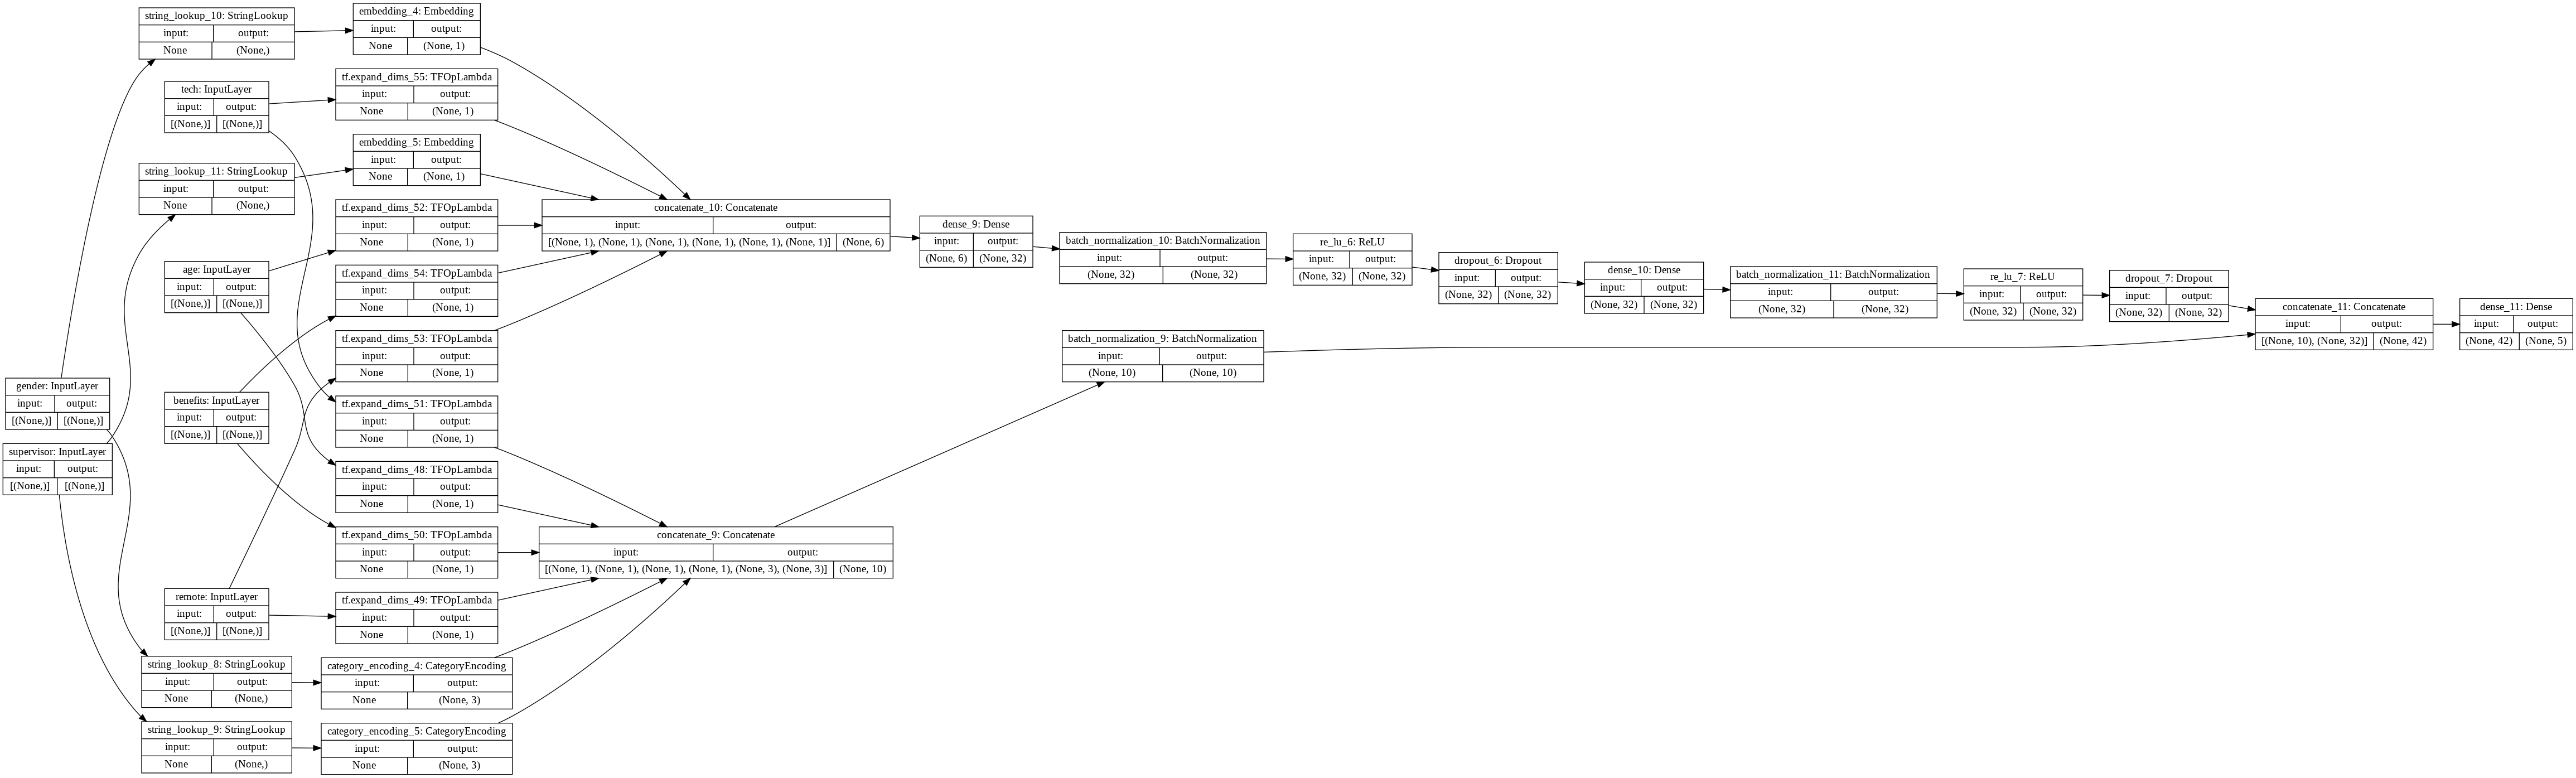

In [ ]:
#wide and deep
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Let's run it:

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
5/5 [==============================] - 1s 6ms/step - loss: 1.9337 - sparse_categorical_accuracy: 0.2204
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.9267 - sparse_categorical_accuracy: 0.2110
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 1.8471 - sparse_categorical_accuracy: 0.2275
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 1.8286 - sparse_categorical_accuracy: 0.2324
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 1.8059 - sparse_categorical_accuracy: 0.2324
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 1.7315 - sparse_categorical_accuracy: 0.2695
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 1.7019 - sparse_categorical_accuracy: 0.2615
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 1.7436 - sparse_categorical_accuracy: 0.2473
Epoch 9/50
5/5 [==============================] - 0s

Emmm what's wrong with the model? The demo code also shows 29.73% accuracy. 

In [ ]:
# embedding extraction
extractor_second_last_layer = keras.Model(inputs=wide_and_deep_model.inputs,
                        outputs=[wide_and_deep_model.layers[-2].output])

extractor_last_layer = keras.Model(inputs=wide_and_deep_model.inputs,
                        outputs=[wide_and_deep_model.layers[-1].output])

In [ ]:
import csv

def get_embedding(data_df,index,category):
    row=data_df.iloc[index]
    with open("row.csv","w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list(row.index))
        writer.writerow(list(row.values))
    sample = get_dataset_from_csv('row.csv', 1)
    for data in sample.as_numpy_iterator():
        data_point = data
    if category=='last':
        return extractor_last_layer(dict(data_point[0]))
    elif category=='second_last':
        return extractor_second_last_layer(dict(data_point[0]))
    else:
        print('category should be either "last" or "second_last" ')

In [ ]:
get_embedding(test_data,100,'last')

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.11822844, 0.24096622, 0.31413406, 0.21894409, 0.10772719]],
      dtype=float32)>

In [ ]:
get_embedding(train_data,500,'second_last')

<tf.Tensor: shape=(1, 42), dtype=float32, numpy=
array([[ 1.0860162 , -0.37736577,  1.2061636 ,  0.5649524 , -0.00222081,
        -0.53127694,  0.5935211 ,  1.1020007 , -0.4002224 , -0.4413664 ,
         0.45677343,  0.41552836,  0.68917644,  0.        ,  0.        ,
         0.        ,  0.        ,  0.7969216 ,  0.        ,  0.28822738,
         0.82343   ,  0.5013692 ,  0.2766388 ,  0.        ,  0.        ,
         0.82386726,  0.83588374,  0.3238405 ,  0.88354206,  0.        ,
         0.        ,  0.5454124 ,  0.30825227,  0.        ,  1.1464876 ,
         0.674133  ,  0.4126112 ,  0.        ,  0.5152475 ,  0.81858134,
         0.21983206,  0.        ]], dtype=float32)>

**3)** Use any categorical or tabular embedding method on your data.

In [27]:
df

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,budget,openWeek,WorldGross,USCAGross,genre,label
0,1999,7.3,70.000000,7.6,70.0,5.8,30000000.0,8.330681e+06,5.347858e+07,3.817817e+07,comedy,0
1,1992,6.4,47.000000,6.2,32.0,5.8,47000000.0,3.002680e+06,7.191399e+06,7.191399e+06,adventure,1
2,1997,6.9,79.000000,6.4,88.0,7.1,6000000.0,6.397900e+04,6.330054e+06,6.330054e+06,drama,1
3,1987,6.8,66.000000,6.8,82.0,6.3,27000000.0,4.739913e+06,2.589381e+07,2.589381e+07,action,0
4,1999,7.8,84.000000,7.5,96.0,7.2,90000000.0,6.712361e+06,6.028991e+07,2.908991e+07,biography,1
...,...,...,...,...,...,...,...,...,...,...,...,...
595,2007,7.2,65.000000,7.2,68.0,6.5,150000000.0,7.721132e+07,5.854101e+08,2.563930e+08,drama,1
596,1953,6.3,63.214971,6.0,82.0,5.7,290000.0,1.119634e+07,1.066377e+08,5.933545e+07,horror,0
597,1996,7.0,59.000000,6.8,68.0,5.3,75000000.0,5.022826e+07,8.174009e+08,3.061693e+08,action,0
598,1989,8.2,65.000000,7.8,88.0,7.8,48000000.0,2.935502e+07,4.741718e+08,1.971718e+08,action,1


In [35]:
df['genre_encoding'] = df['genre'].replace(list(df['genre'].unique()), list(range(17)))
df

,year,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,budget,openWeek,WorldGross,USCAGross,genre,label,genre_encoding
0,1999,7.3,70.000000,7.6,70.0,5.8,30000000.0,8.330681e+06,5.347858e+07,3.817817e+07,comedy,0,0
1,1992,6.4,47.000000,6.2,32.0,5.8,47000000.0,3.002680e+06,7.191399e+06,7.191399e+06,adventure,1,1
2,1997,6.9,79.000000,6.4,88.0,7.1,6000000.0,6.397900e+04,6.330054e+06,6.330054e+06,drama,1,2
3,1987,6.8,66.000000,6.8,82.0,6.3,27000000.0,4.739913e+06,2.589381e+07,2.589381e+07,action,0,3
4,1999,7.8,84.000000,7.5,96.0,7.2,90000000.0,6.712361e+06,6.028991e+07,2.908991e+07,biography,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2007,7.2,65.000000,7.2,68.0,6.5,150000000.0,7.721132e+07,5.854101e+08,2.563930e+08,drama,1,2
596,1953,6.3,63.214971,6.0,82.0,5.7,290000.0,1.119634e+07,1.066377e+08,5.933545e+07,horror,0,6
597,1996,7.0,59.000000,6.8,68.0,5.3,75000000.0,5.022826e+07,8.174009e+08,3.061693e+08,action,0,3
598,1989,8.2,65.000000,7.8,88.0,7.8,48000000.0,2.935502e+07,4.741718e+08,1.971718e+08,action,1,3


In [36]:
embedding_size = 3

model = models.Sequential()
model.add(Embedding(input_dim = 17, output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(x = df['genre_encoding'].values, y=df['IMDB'].values , epochs = 50, batch_size = 4)


Epoch 1/50
150/150 [==============================] - 3s 2ms/step - loss: 26.3403 - accuracy: 0.0000e+00
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 1.0974 - accuracy: 0.0000e+00
Epoch 3/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9666 - accuracy: 0.0000e+00
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9411 - accuracy: 0.0000e+00
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9308 - accuracy: 0.0000e+00
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9357 - accuracy: 0.0000e+00
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9275 - accuracy: 0.0000e+00
Epoch 8/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9390 - accuracy: 0.0000e+00
Epoch 9/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9375 - accuracy: 0.0000e+00
Epoch 10/50
150/150 [==============================] - 0s 2ms/s

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 3)              51        
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 15)                765       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,032
Trainable params: 1,032
Non-trainable params: 0
_________________________________________________________________


In [38]:
layer = model.get_layer('embedding')
output_embeddings = layer.get_weights()
output_embeddings

[array([[-0.0837232 ,  0.08969742,  0.02286792],
        [-0.13142793,  0.10814653,  0.14417307],
        [-0.08019397,  0.1607926 ,  0.09890272],
        [-0.03408555,  0.06235136,  0.03998271],
        [-0.20333679,  0.10301044,  0.14569563],
        [-0.15165862,  0.0887485 ,  0.08393672],
        [-0.01167262, -0.04338419,  0.0008238 ],
        [ 0.05828517, -0.02870015, -0.03465731],
        [-0.1350503 ,  0.06839777,  0.12128422],
        [ 0.02998465, -0.06139817,  0.00181165],
        [-0.11876046,  0.07049564,  0.04924929],
        [-0.02495996,  0.05218594,  0.06428664],
        [ 0.03830275,  0.0088867 ,  0.00741392],
        [ 0.11318541, -0.07975885, -0.05369928],
        [-0.16573146,  0.14854577,  0.20177013],
        [-0.12995069,  0.10110066,  0.11381923],
        [-0.21888112,  0.16130899,  0.14957981]], dtype=float32)]

In [39]:
output_embeddings_df = pd.DataFrame(output_embeddings[0])
output_embeddings_df = output_embeddings_df.reset_index()
output_embeddings_df.columns = ['genre_encoding', 'embedding_1', 'embedding_2', 'embedding_3']
output_embeddings_df

,genre_encoding,embedding_1,embedding_2,embedding_3
0,0,-0.083723,0.089697,0.022868
1,1,-0.131428,0.108147,0.144173
2,2,-0.080194,0.160793,0.098903
3,3,-0.034086,0.062351,0.039983
4,4,-0.203337,0.103010,0.145696
5,5,-0.151659,0.088748,0.083937
6,6,-0.011673,-0.043384,0.000824
7,7,0.058285,-0.028700,-0.034657
8,8,-0.135050,0.068398,0.121284
9,9,0.029985,-0.061398,0.001812


### Vizualisation

In [40]:
output_embeddings_df.iloc[:,1:]

,embedding_1,embedding_2,embedding_3
0,-0.083723,0.089697,0.022868
1,-0.131428,0.108147,0.144173
2,-0.080194,0.160793,0.098903
3,-0.034086,0.062351,0.039983
4,-0.203337,0.103010,0.145696
5,-0.151659,0.088748,0.083937
6,-0.011673,-0.043384,0.000824
7,0.058285,-0.028700,-0.034657
8,-0.135050,0.068398,0.121284
9,0.029985,-0.061398,0.001812


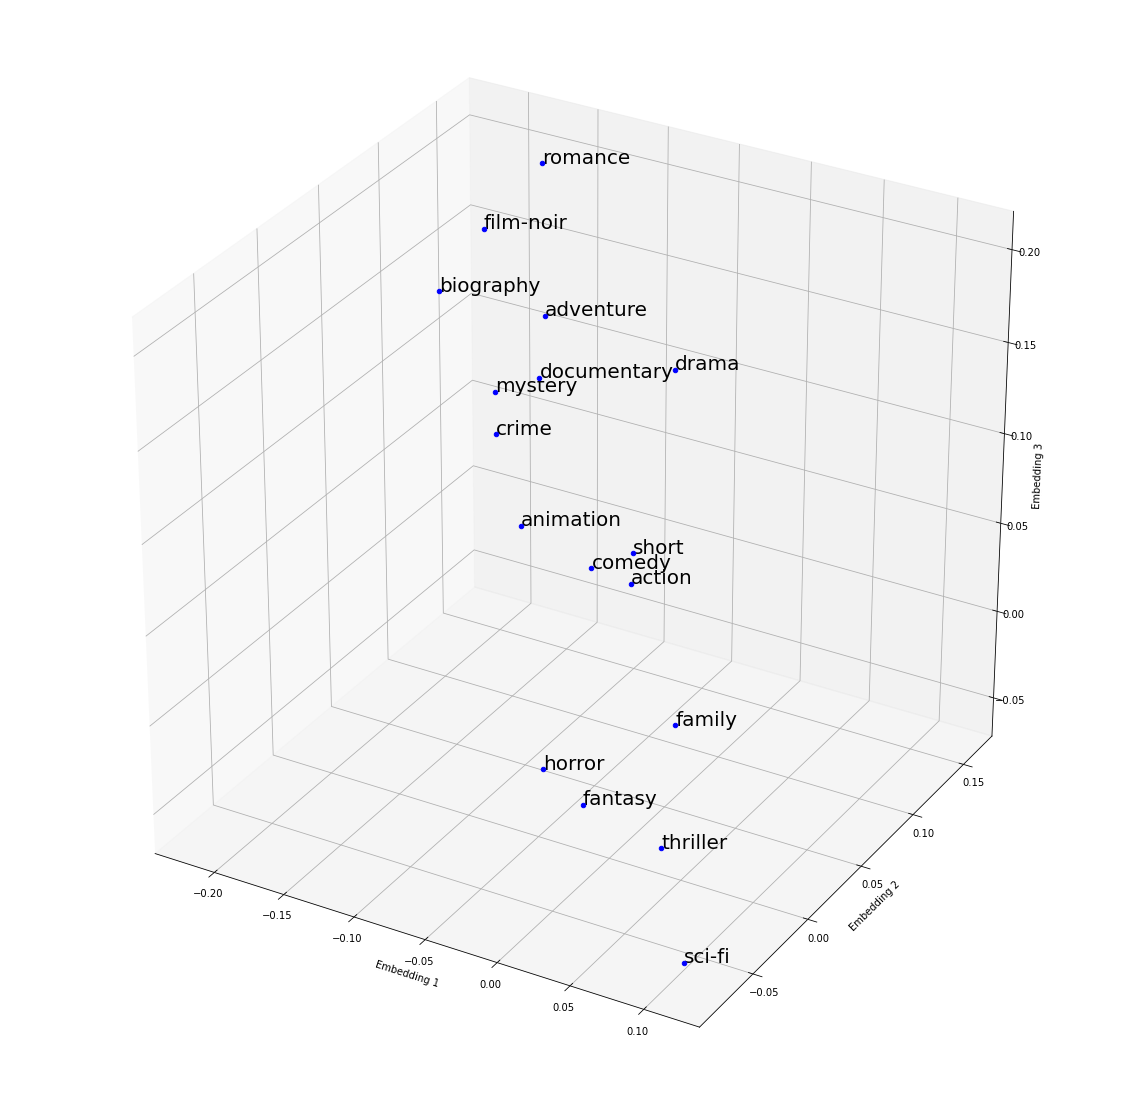

In [42]:
m = output_embeddings_df.iloc[:,1:].values
labels = list(df['genre'].unique())
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(labels)):
    ax.scatter(m[i,0],m[i,1],m[i,2], color='b')
    ax.text(m[i,0],m[i,1],m[i,2],'%s'%(str(labels[i])), size=20, zorder=1, color='k')

ax.set_xlabel('Embedding 1')  
ax.set_ylabel('Embedding 2')  
ax.set_zlabel('Embedding 3')  
plt.show()

**4)** Create a knowledge graph dataset relevant to your social science interest.

**5)** Run a knowledge graph embedding algorithm on your dataset. Visualise your embeddings and run distance metrics on them.

## Hint

Here is a hint notebook to ingest data for some of these models: [Likun Hint Notebook](https://colab.research.google.com/drive/1kgPM1KcOo0YVHQVSBSsWNwfXweUhs5q0?usp=sharing)